<font ><b><h1 style="font-size:3em; font-family:sans-serif"><center>Solving the Mean-Field Galactic Dynamo Equation along the z-axis</center></h1></b>

# PART 1

## Code

Importing Packages

In [93]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.graph_objects as go
%matplotlib widget
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")
fig_s=800

### Defining Functions

Defining the Crank Nicolson Function

In [94]:
def crank_nicolson(u0, dx, dt, T,eta):
    """
    u0: initial condition, a function of x
    dx: space step size
    dt: time step size
    T: total time upto which integration is to be done
    """
    N = int(T/dt)
    J = len(u0)
    u = np.empty((N, J))
    u[0] = u0
    sigma = eta*dt / (dx**2)

    # Construct the tridiagonal matrices
    P=np.diag(2+2*sigma*np.ones(J))+np.diag(-sigma* np.ones(J-1), -1)+np.diag(-sigma* np.ones(J-1), 1)
    Q=np.diag(2-2*sigma*np.ones(J))+np.diag(sigma* np.ones(J-1), -1)+np.diag(sigma* np.ones(J-1), 1)
    # Iterating for each time step
    for n in range(N-1):
        b = u[n]
        # print(n)
        u[n+1] =  np.linalg.solve(P, np.dot(Q, b))
        u[n+1, 0] = u[n, 0]
        u[n+1, -1] = u[n, -1]
    return u

Calculating pitch angle

In [95]:
def b_total_pitch(B_r,B_phi):
    return np.sqrt(B_r**2+B_phi**2), np.where(B_phi!=0, np.arctan(B_r/B_phi)*180/np.pi, np.sign(B_r)*90)

Calculating decay factor gamma

In [96]:
def decay_factor(B_t,t,pl=0,q=0):
    log_B_t=np.log(B_t)
    # Plot log_B_t vs t


    # Fit a line to the last 100 data points
    
    slope, intercept, _, _, _ = linregress(t[-50:], log_B_t[-50:])
    fitted_line = slope * t[-50:] + intercept

    # Plot the fitted line
    if pl==0:
        fig1=plt.figure(dpi=250)
        plt.plot(t, log_B_t, label='log_B_t')
        plt.plot(t[-50:], fitted_line, label='Fitted Line')

        # Set labels and title
        plt.xlabel('t (Myr)')
        plt.ylabel(r'$log(B_{total} (G))$')
        plt.title(r'Plot of $log(B_{total})$ vs t')

        # Add legend
        plt.legend()
        plt.savefig(f'images_sim/decay_rate{q}')
        # Show the plot
        plt.show()
    return slope

Creating animations

In [97]:
def create_ani(B,z_values,t_values,file_n,label):
    fig, ax = plt.subplots(dpi=200)
    def update(frame):
        ax.clear()
        ax.plot(z_values, B[frame, :])
        ax.set_title(f'Time={int(t_values[frame])}Myr')
        ax.set_xlabel(label[0])
        ax.set_ylabel(label[1])
        ax.set_xlim(z_values.min(), z_values.max())
        # ax.set_ylim().min(), B_array.max())

    ani = animation.FuncAnimation(fig, update, frames=len(t_values), interval=100)

    ani.save(file_n, writer='pillow')
    plt.close(fig)

### Applying specific Boundary Conditions

### 1) $B_{0r}=10^{-6}(\frac{3z}{z_{max}}+sin\left(\frac{3z}{z_{max}}\right)e^{-(\frac{3z}{z_{max}})^2})G$
### $\;\;\,$ $B_{0\phi}=10^{-6}sin\left(\frac{3\pi (z-z_{max})}{2z_{max}}\right)G$

Boundary conditions resolution and other parameters

In [98]:
#Spatial resolution and spatial domain
z_min = -150 #pc
z_max = 150 #pc
dz = 1 #pc
#Array of all spatial points
z_val = np.arange(z_min, z_max + dz, dz)
#Time resolution and time upto which integration is to be done
t_f=70 #Myr
dt=0.1 #Myr

t_val = np.arange(0, t_f, dt)
#Initial condition
B0_R=(1e-6)*((3*z_val/z_max) + np.sin(3*z_val/z_max)) * np.exp(-(3*z_val/z_max)**2.0)
B0_PHI=(1e-6)*np.sin(np.pi*(3*(z_val-z_max)/(2*z_max)))
#Diffusion parameter
eta=348

Plotting seed magnetic field

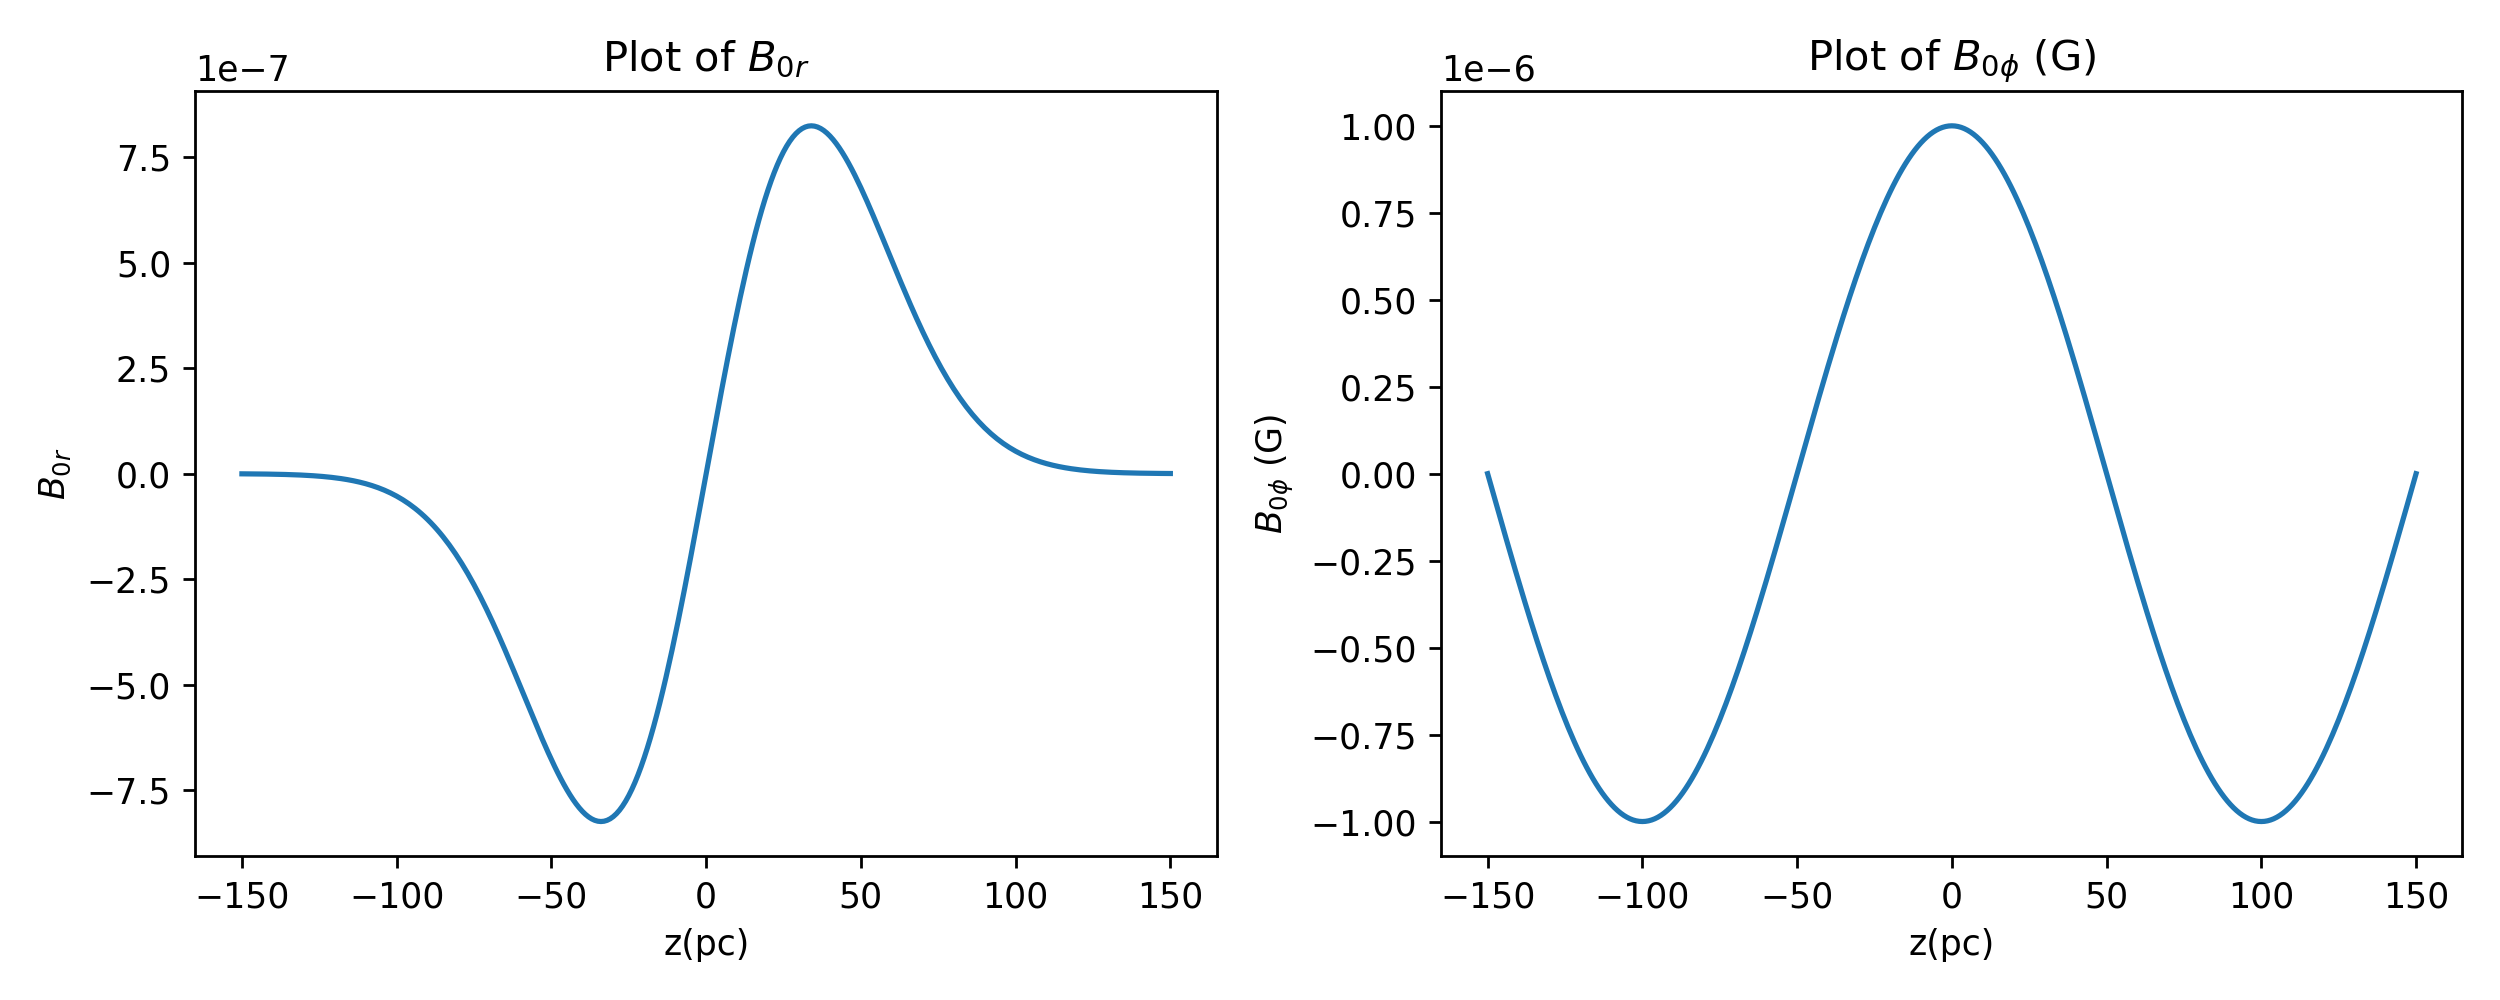

In [99]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 4], dpi=250)

# Plot of B0_R
axs[0].plot(z_val, B0_R)
axs[0].set_xlabel('z(pc)')
axs[0].set_ylabel(r'$B_{0r}$')
axs[0].set_title(r'Plot of $B_{0r}$')

# Plot of B0_PHI
axs[1].plot(z_val, B0_PHI)
axs[1].set_xlabel('z(pc)')
axs[1].set_ylabel(r'$B_{0\phi}$ (G)')
axs[1].set_title(r'Plot of $B_{0\phi}$ (G)')

plt.tight_layout()
plt.savefig('images_sim/seed_field11.png')
plt.show()

Plotting B in 3d

Plotting variation of $B_{r}$ with time

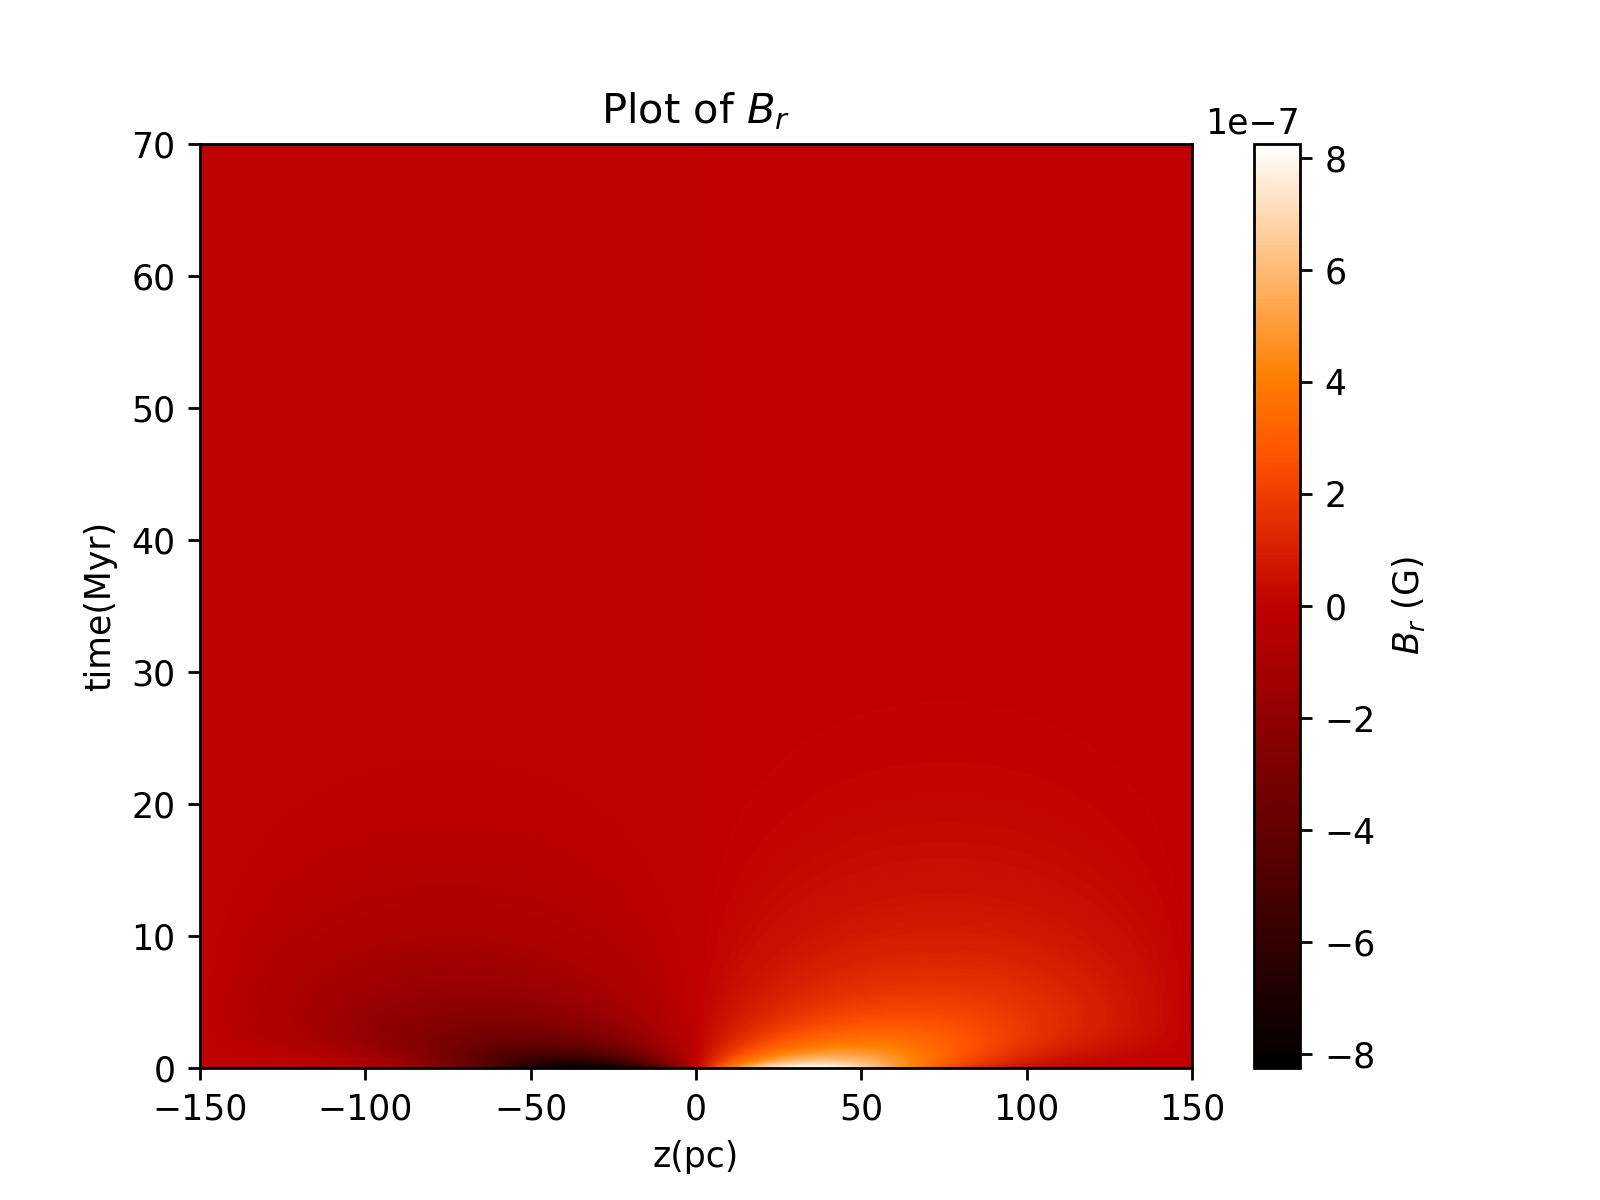

In [100]:
B_R = crank_nicolson(B0_R, dz, dt, t_f,eta)
fig1=plt.figure(dpi=250)
plt.imshow(B_R, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$B_{r}$ (G)')
plt.xlabel('z(pc)')
plt.ylabel('time(Myr)')
plt.title(r'Plot of $B_{r}$')
plt.savefig('images_sim/B_r11_heat.png')
plt.show()

Plotting variation of $B_{\phi}$ with time

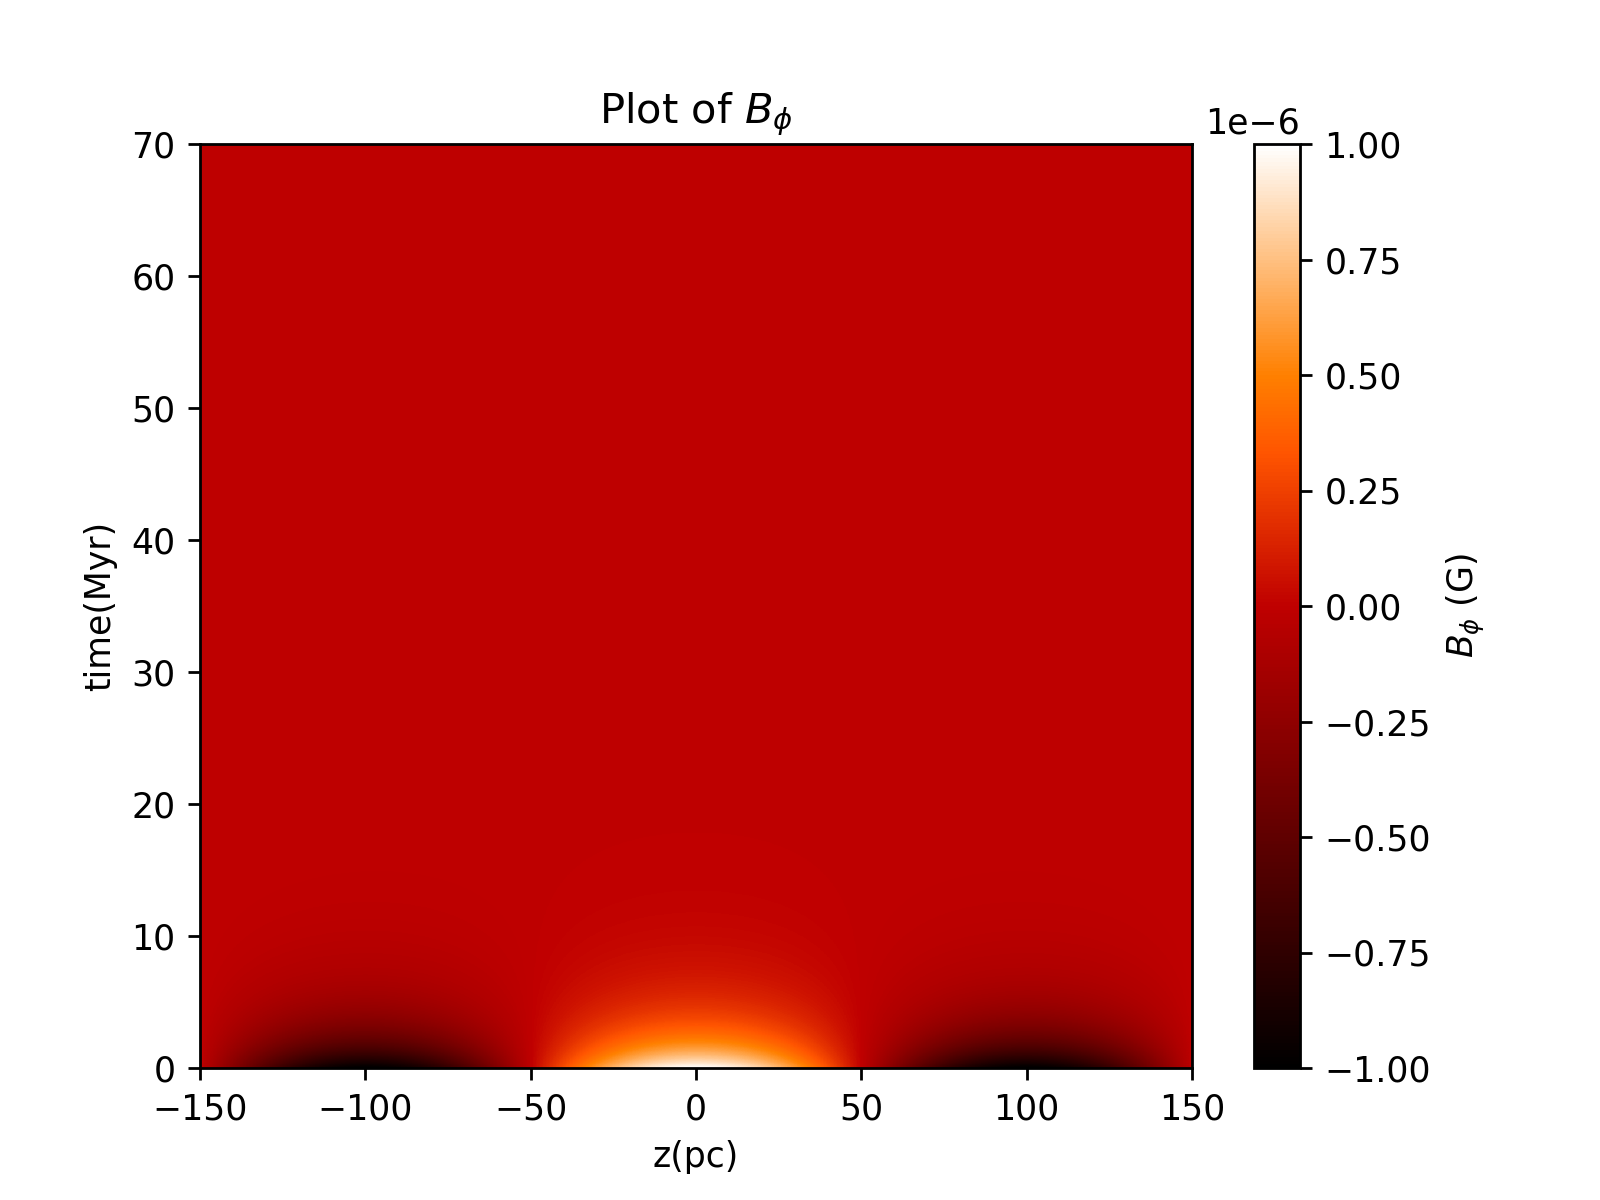

In [101]:
B_PHI = crank_nicolson(B0_PHI, dz, dt, t_f,eta)
fig1=plt.figure(dpi=250)
plt.imshow(B_PHI, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$B_{\phi}$ (G)')
plt.xlabel('z(pc)')
plt.ylabel('time(Myr)')
plt.title(r'Plot of $B_{\phi}$')
plt.savefig('images_sim/B_phi11_heat.png')
plt.show()

Calculating the decay rate $\gamma$ and $B_{total}$

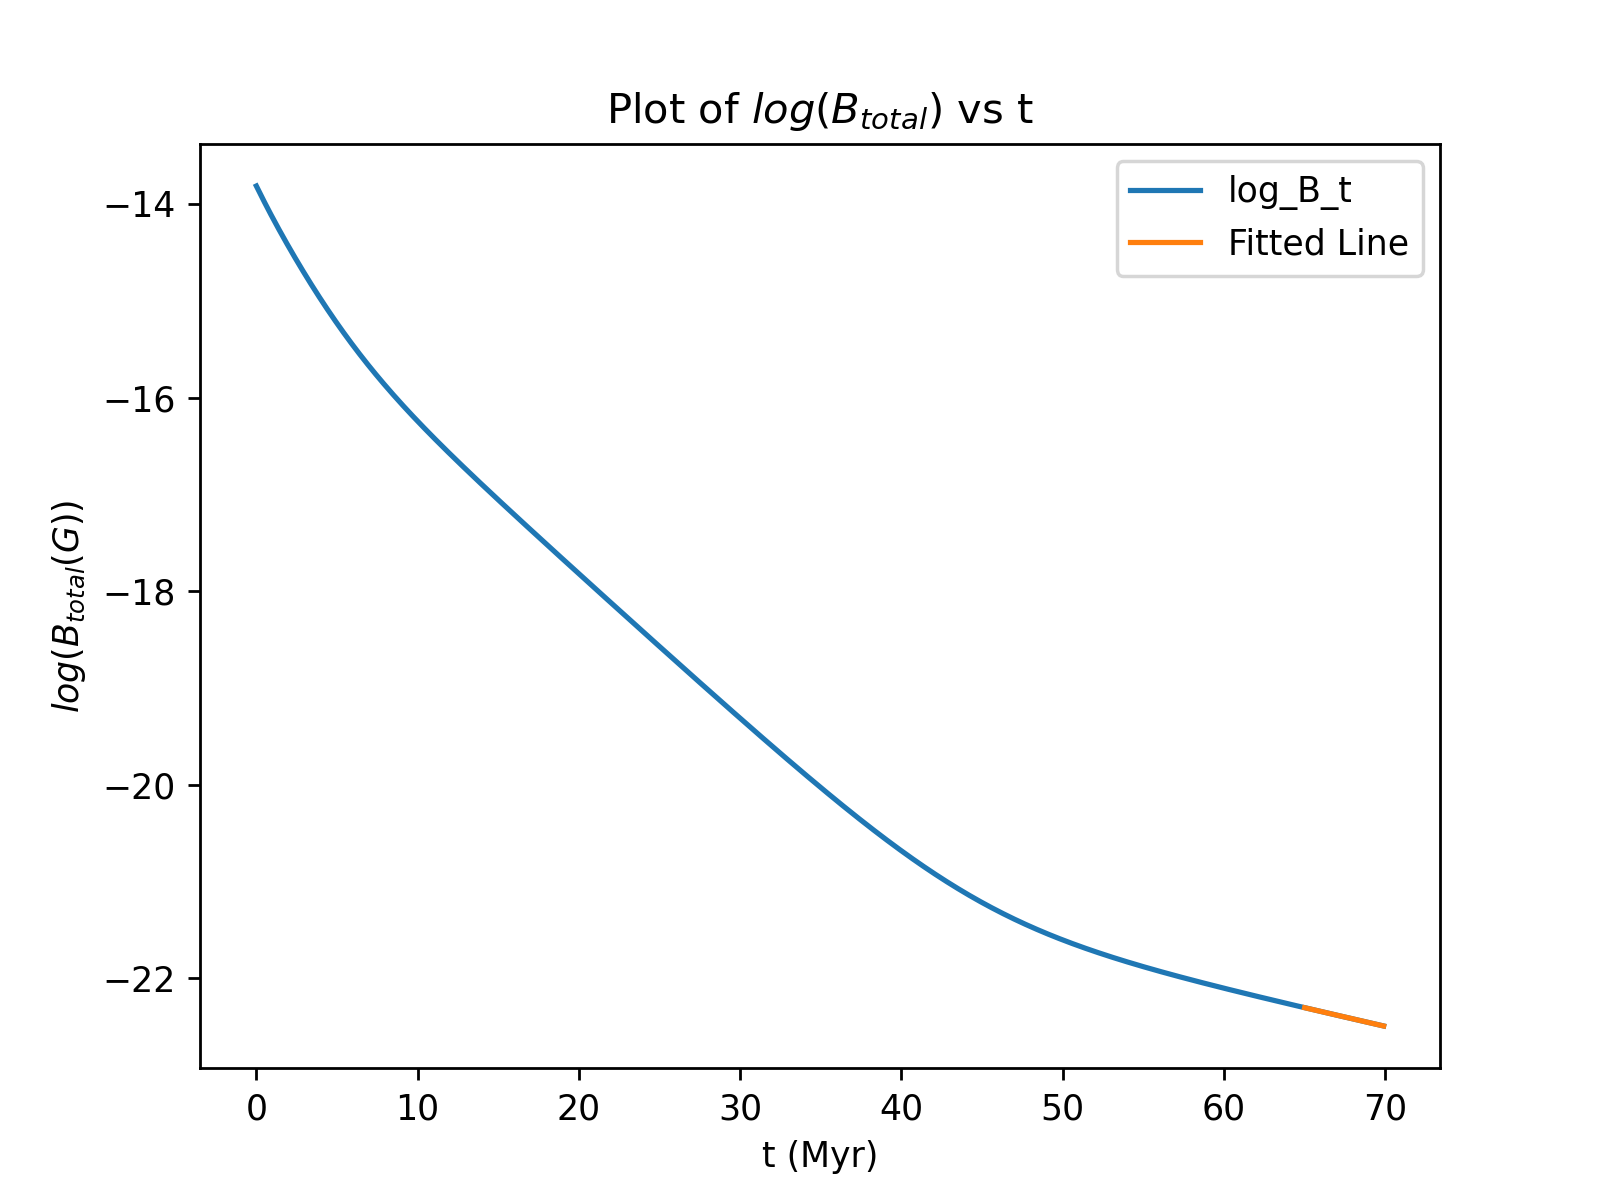

Decay factor gamma for B  0.0385655888410187


In [102]:
B_total,p_b=b_total_pitch(B_R,B_PHI)
gamma=decay_factor(B_total[:,50],t_val,q=11)
print("Decay factor gamma for B ",-gamma)

Ploting variation of $B_{total}$ with time

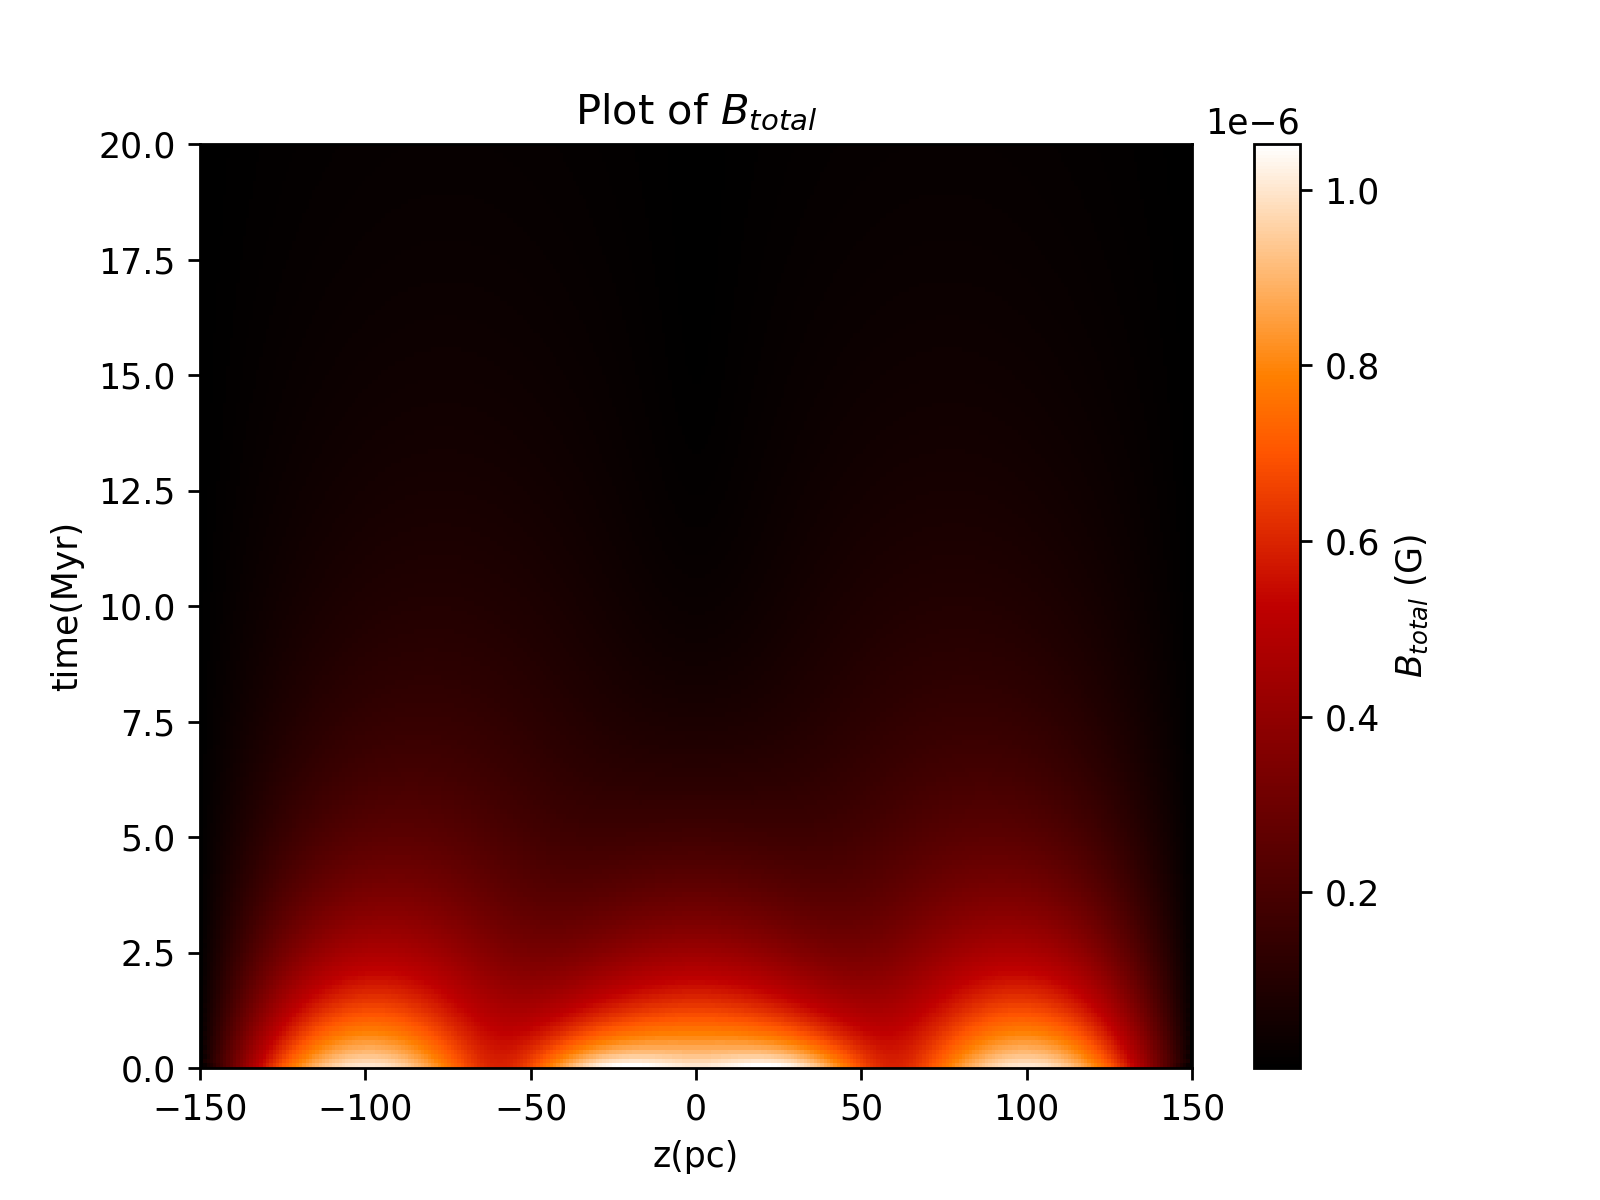

In [103]:
fig1=plt.figure(dpi=250)
plt.imshow(B_total, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$B_{total}$ (G)')
plt.xlabel('z(pc)')
plt.ylabel('time(Myr)')
plt.title(r'Plot of $B_{total}$')
plt.ylim([0,20])
plt.savefig('images_sim/B_t11_heat.png')
plt.show()

In [12]:
# plt.close('all')
create_ani(B_total[::7],z_val,t_val[::7],'animations/B_t11.gif',['z (pc)',r'$B_{tot}$ (G)'])

![Variation of Total B with time](animations/B_t11.gif?dummy=1526)

Plotting pitch angle $P_b$ versus time

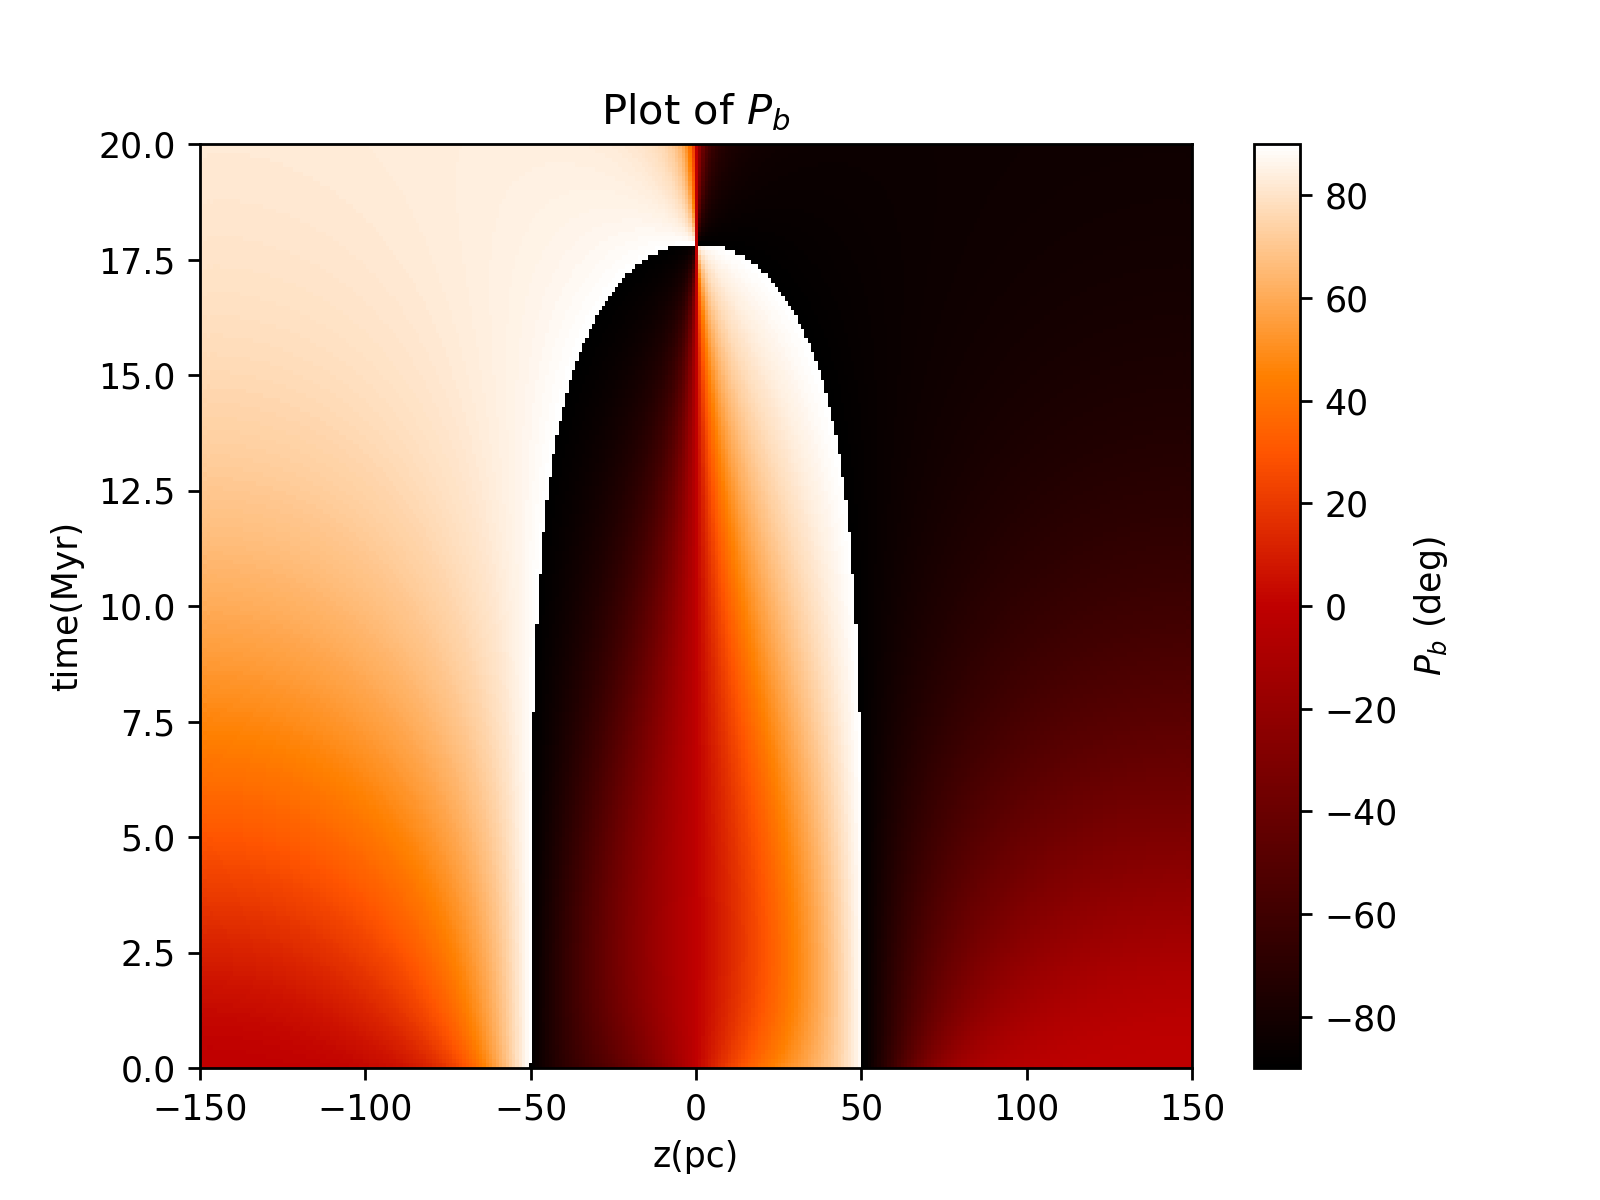

In [13]:
fig1=plt.figure(dpi=250)
plt.imshow(p_b[:][:,1:-1], cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$P_b$ (deg)')
plt.xlabel('z(pc)')
plt.ylabel('time(Myr)')
plt.title(r'Plot of $P_b$')
plt.ylim([0,20])
plt.savefig('images_sim/P_b11_heat.png')
plt.show()

In [14]:
create_ani(p_b[:][:,1:-1][::7],z_val[1:-1],t_val[::7],'animations/P_b11.gif',['z (pc)',r'$P_b$ (deg)'])

![Pitch angle variation with time](animations/P_b11.gif?dummy=4121)

### 2) $B_{0r}=10^{-6}\left\{\frac{3z}{z_{max}}+1+sin\left(\frac{3z}{z_{max}}+1\right)e^{-(\frac{3z}{z_{max}}+1)^2}\right\} G$
### $\;\;\,$ $B_{0\phi}=10^{-6}sin\left(\frac{0.5\pi z}{z_{max}}\right) G$

Boundary conditions resolution and other parameters

In [15]:
#Spatial resolution and spatial domain
z_min = -150 #pc
z_max = 150 #pc
dz = 1 #pc
#Array of all spatial points
z_val = np.arange(z_min, z_max + dz, dz)
#Time resolution and time upto which integration is to be done
t_f=30 #Myr
dt=0.1 #Myr

t_val = np.arange(0, t_f, dt)
#Initial condition
B0_R=1e-6*((3*((z_val/z_max)+1)) + np.sin(3*((z_val/z_max)+1))) * np.exp(-(3*((z_val/z_max)+1))**2.0)
B0_PHI=1e-6*np.sin(np.pi*((0.5*(z_val+z_max)/(z_max))))
#Diffusion parameter
eta=348

Plotting seed magnetic field

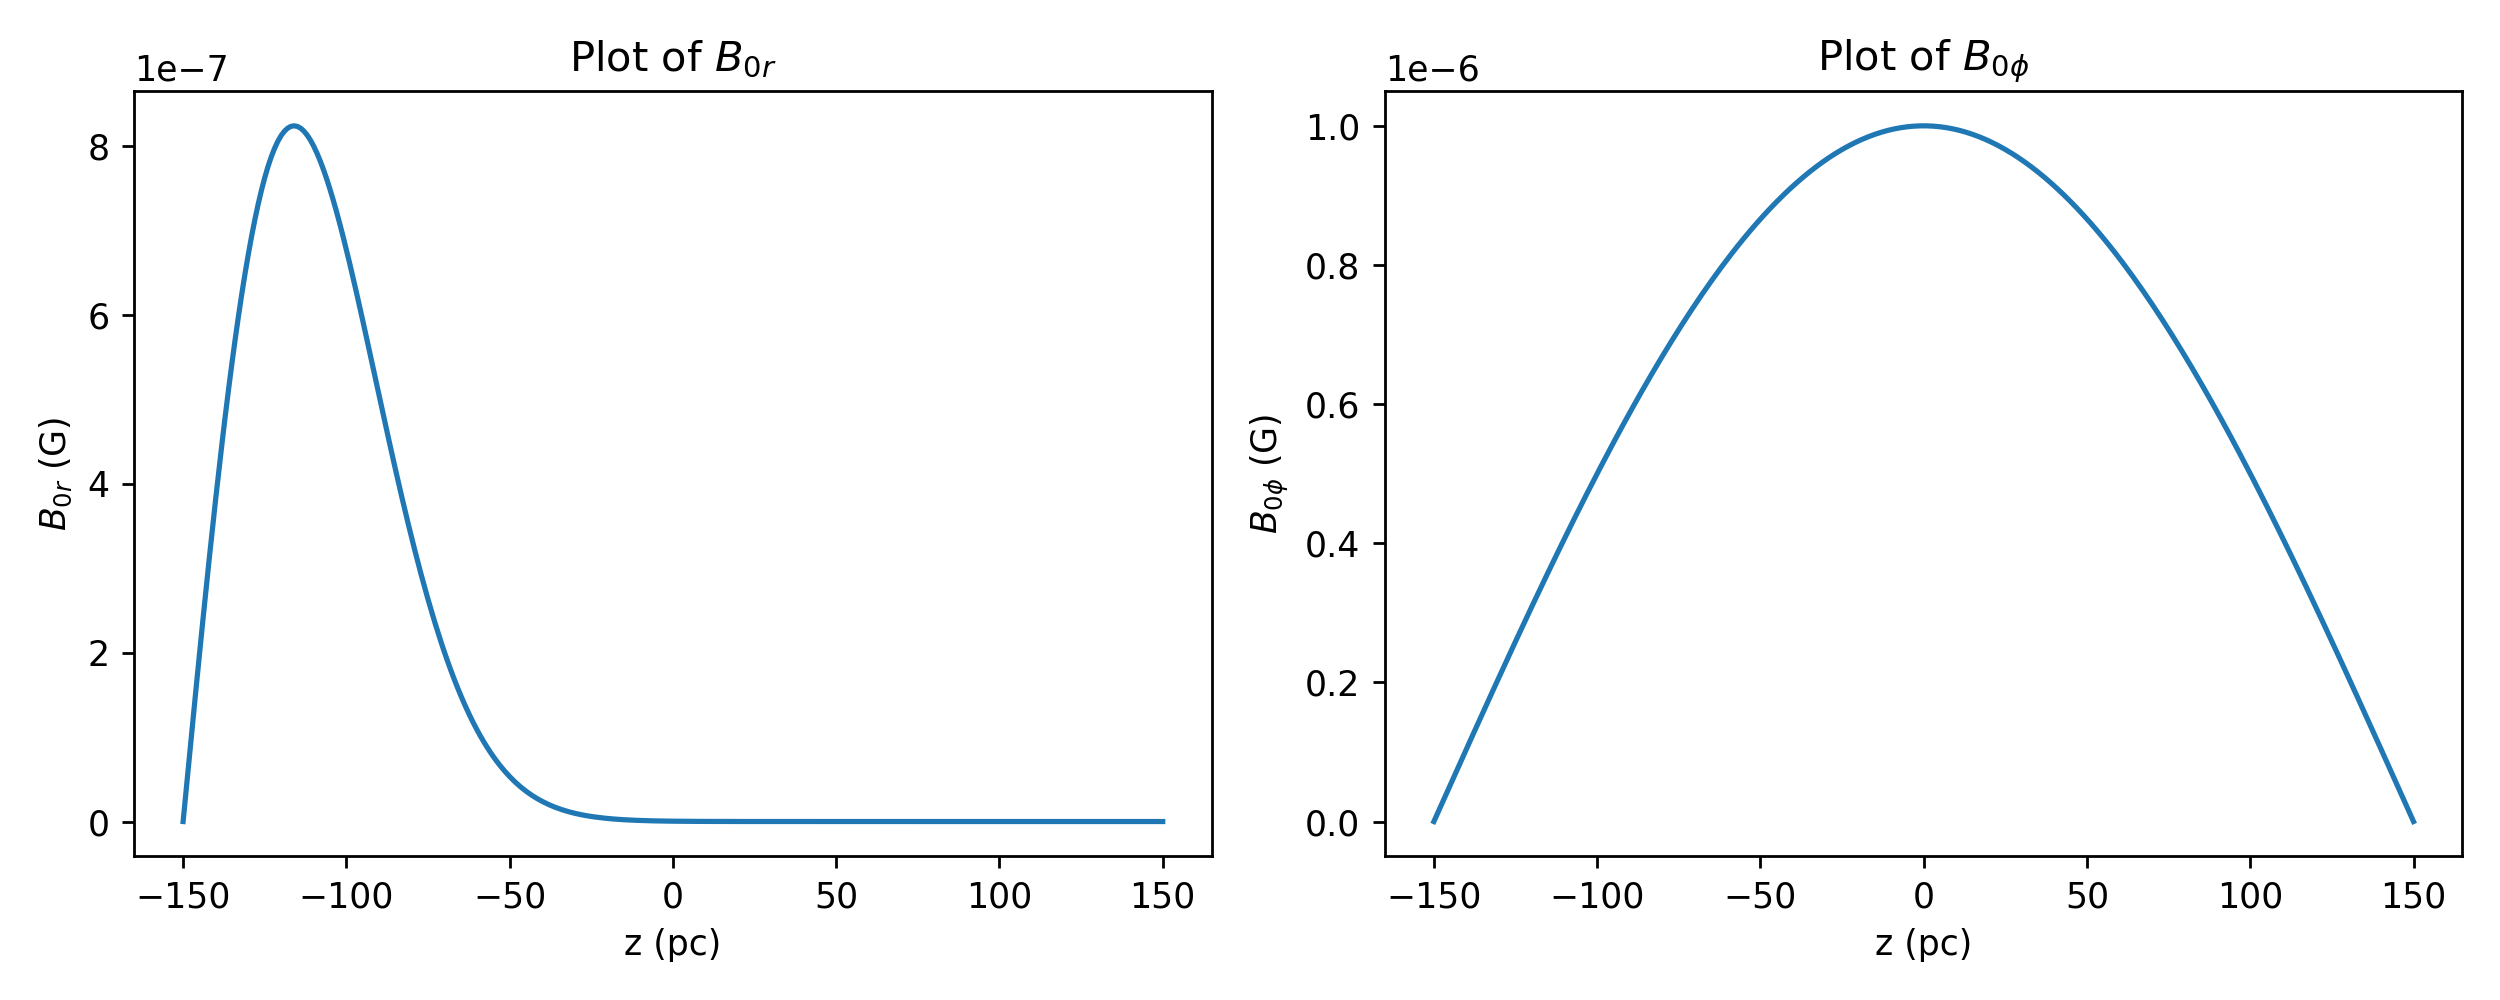

In [16]:
plt.close()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=250)

# Plot of B0_R
axs[0].plot(z_val, B0_R)
axs[0].set_xlabel('z (pc)')
axs[0].set_ylabel(r'$B_{0r}$ (G)')
axs[0].set_title(r'Plot of $B_{0r}$')

# Plot of B0_PHI
axs[1].plot(z_val, B0_PHI)
axs[1].set_xlabel('z (pc)')
axs[1].set_ylabel(r'$B_{0\phi}$ (G)')
axs[1].set_title(r'Plot of $B_{0\phi}$')

plt.tight_layout()

# Save the plot to the "images_sim" folder
plt.savefig('images_sim/seed_field12.png')
plt.show()


Plotting B in 3d

Plotting variation of $B_{r}$ with time

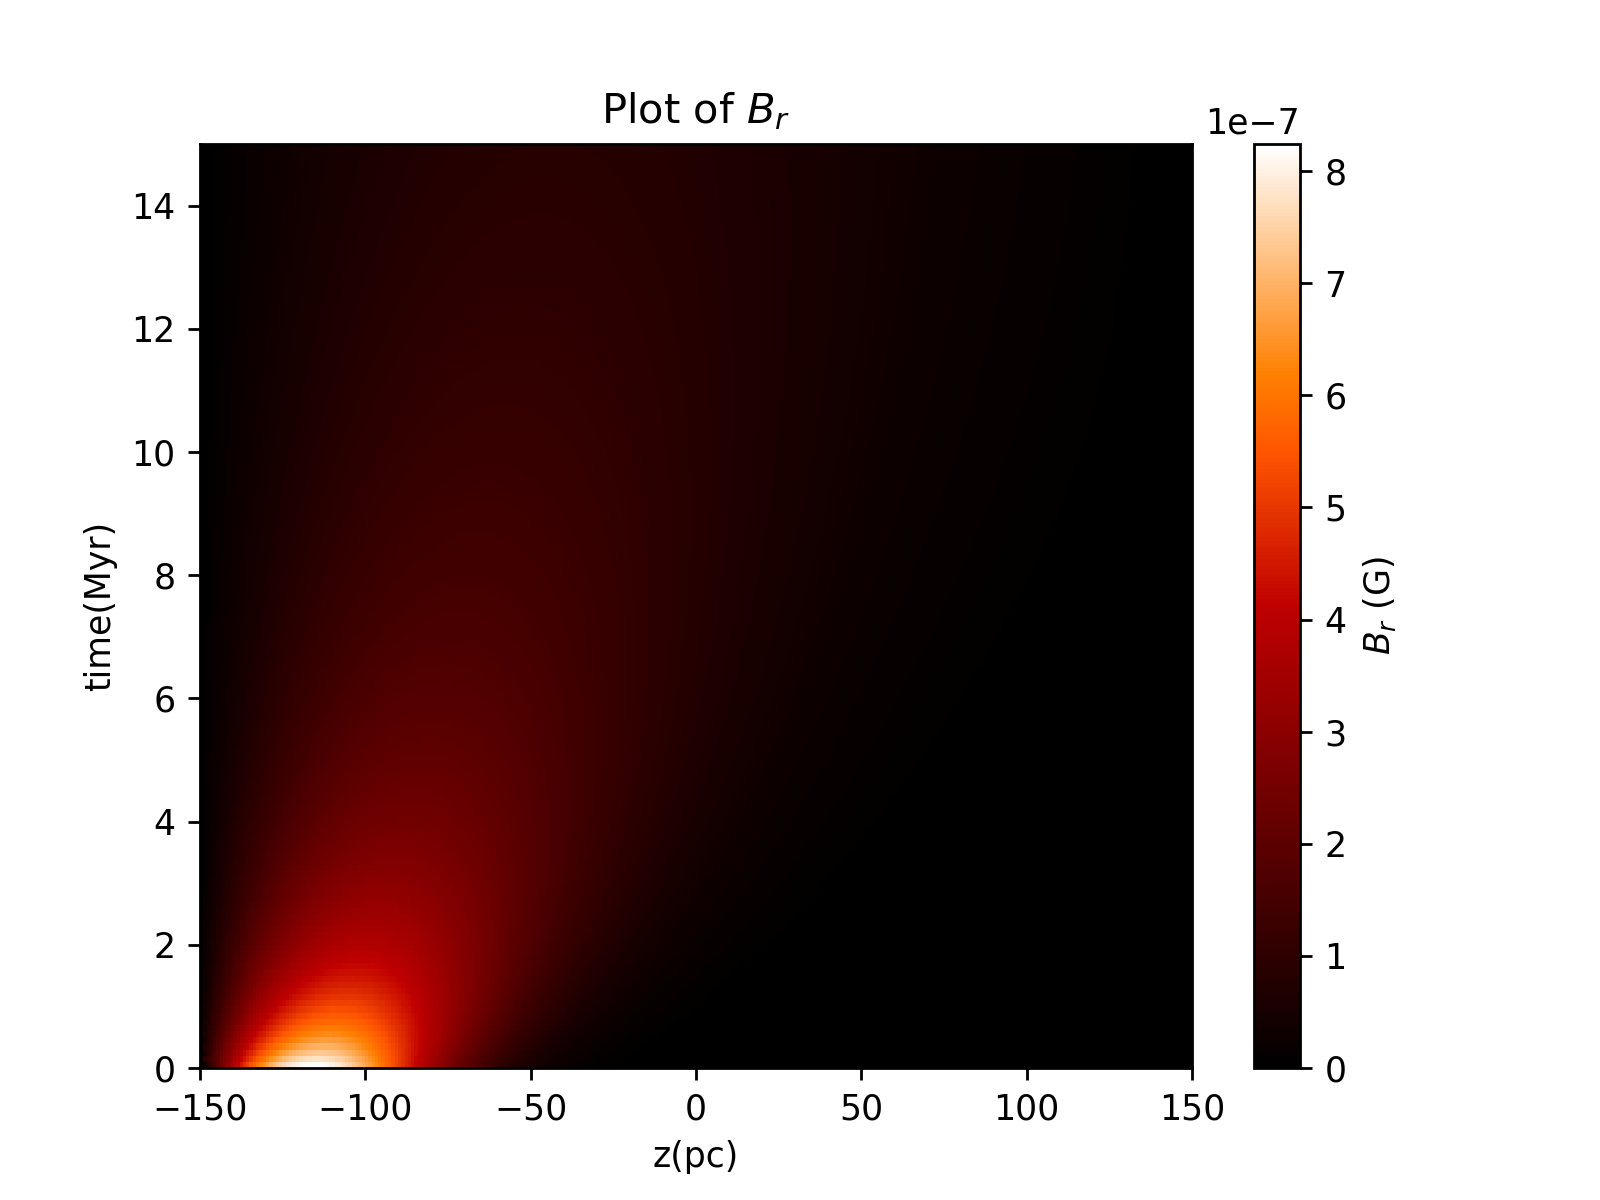

In [17]:
B_R = crank_nicolson(B0_R, dz, dt, t_f,eta)
fig1=plt.figure(dpi=250)
plt.imshow(B_R, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$B_{r}$ (G)')
plt.xlabel('z(pc)')
plt.ylabel('time(Myr)')
plt.title(r'Plot of $B_{r}$')
plt.ylim([0,15])
plt.savefig('images_sim/B_r12_heat.png')
plt.show()

Plotting variation of $B_{\phi}$ with time

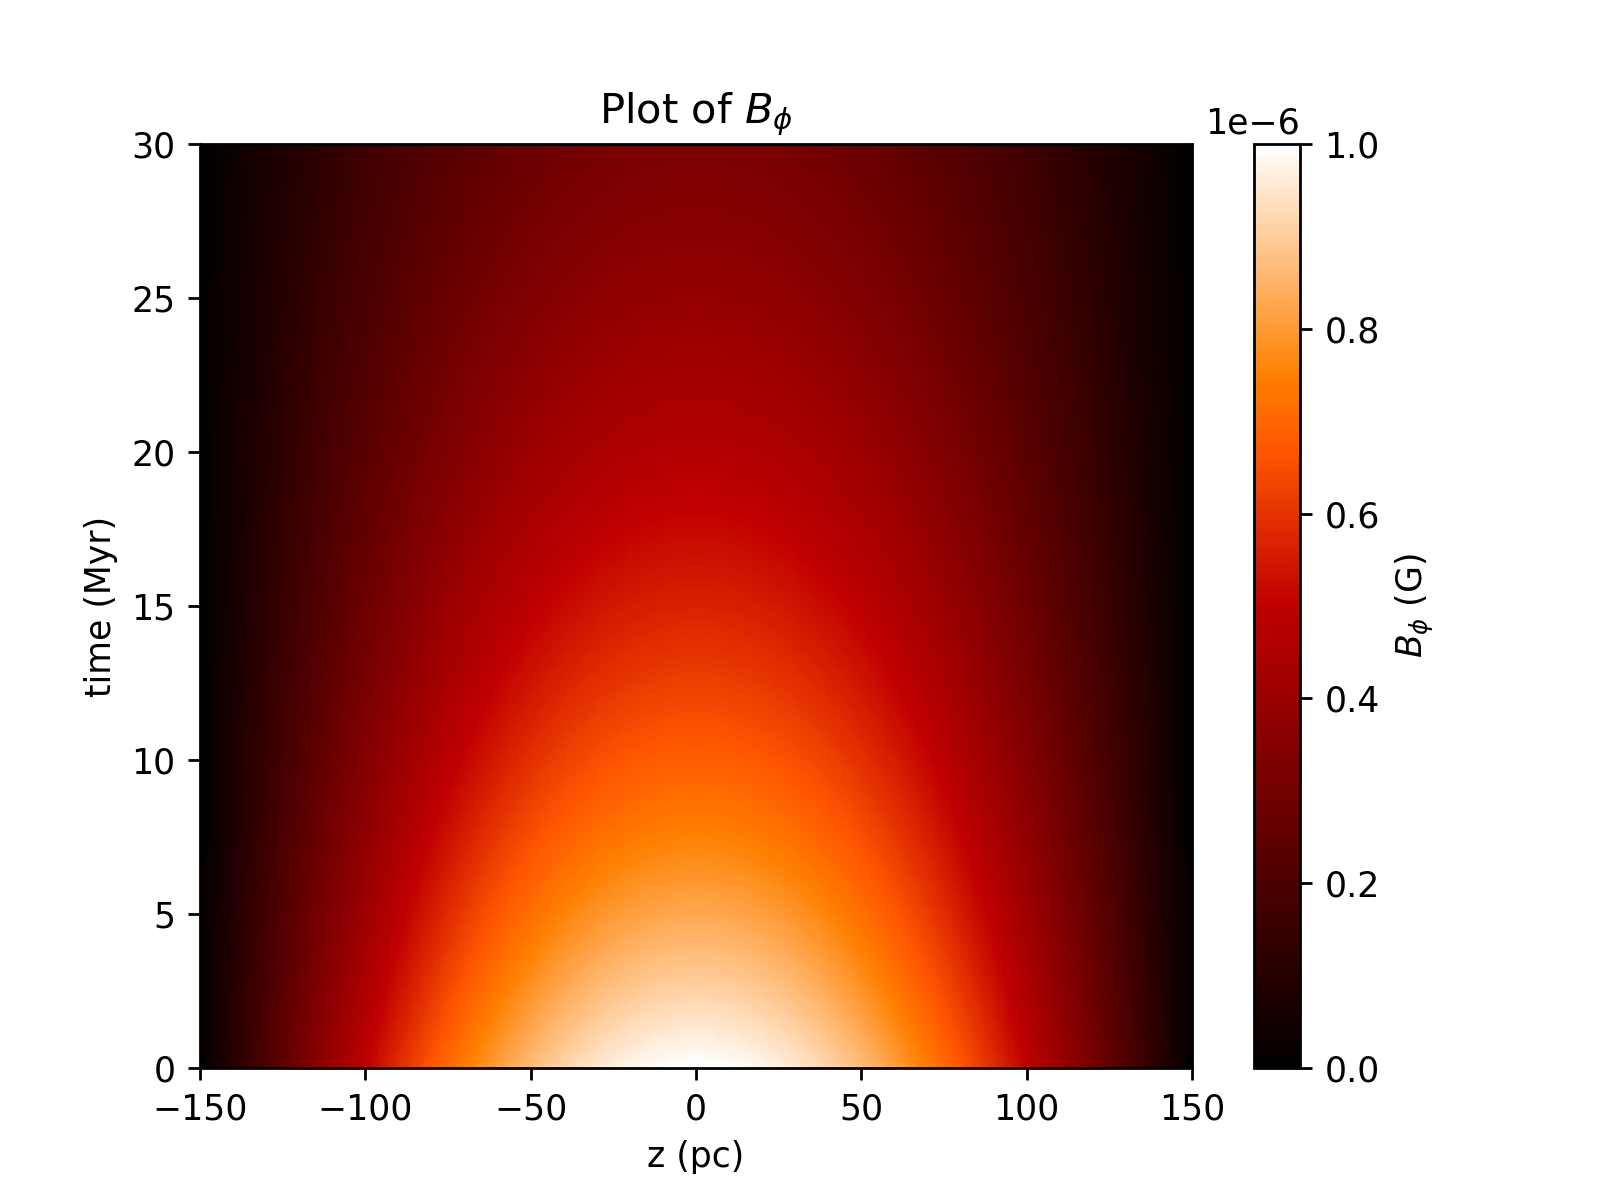

In [18]:
B_PHI = crank_nicolson(B0_PHI, dz, dt, t_f,eta)
fig1=plt.figure(dpi=250)
plt.imshow(B_PHI, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$B_{\phi}$ (G)')
plt.xlabel('z (pc)')
plt.ylabel('time (Myr)')
plt.title(r'Plot of $B_{\phi}$')
plt.savefig('images_sim/B_phi12_heat.png')
plt.show()

Calculating the decay rate $\gamma$ and $B_{total}$

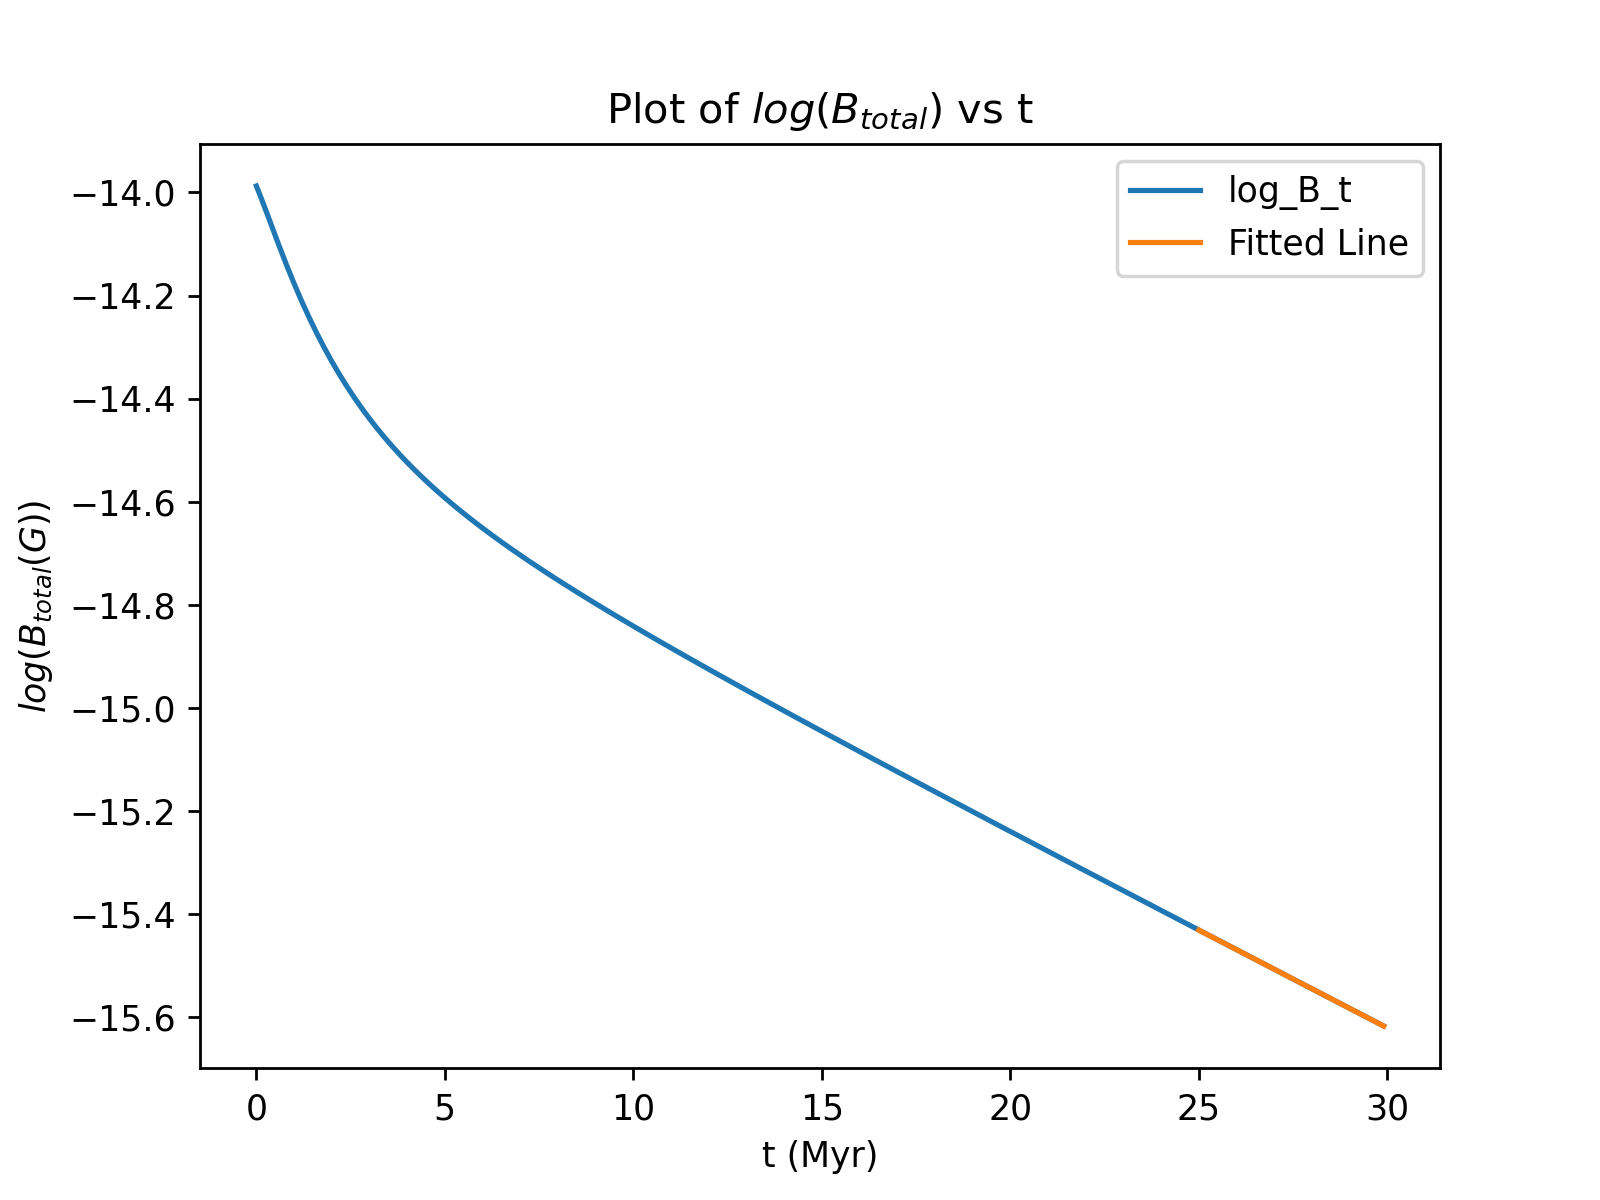

Decay factor gamma for B  0.037965598689969515


In [19]:
B_total,p_b=b_total_pitch(B_R,B_PHI)
gamma=decay_factor(B_total[:,50],t_val,q=12)
# Show the plot
# plt.show()
print("Decay factor gamma for B ",-gamma)

Ploting variation of $B_{total}$ with time

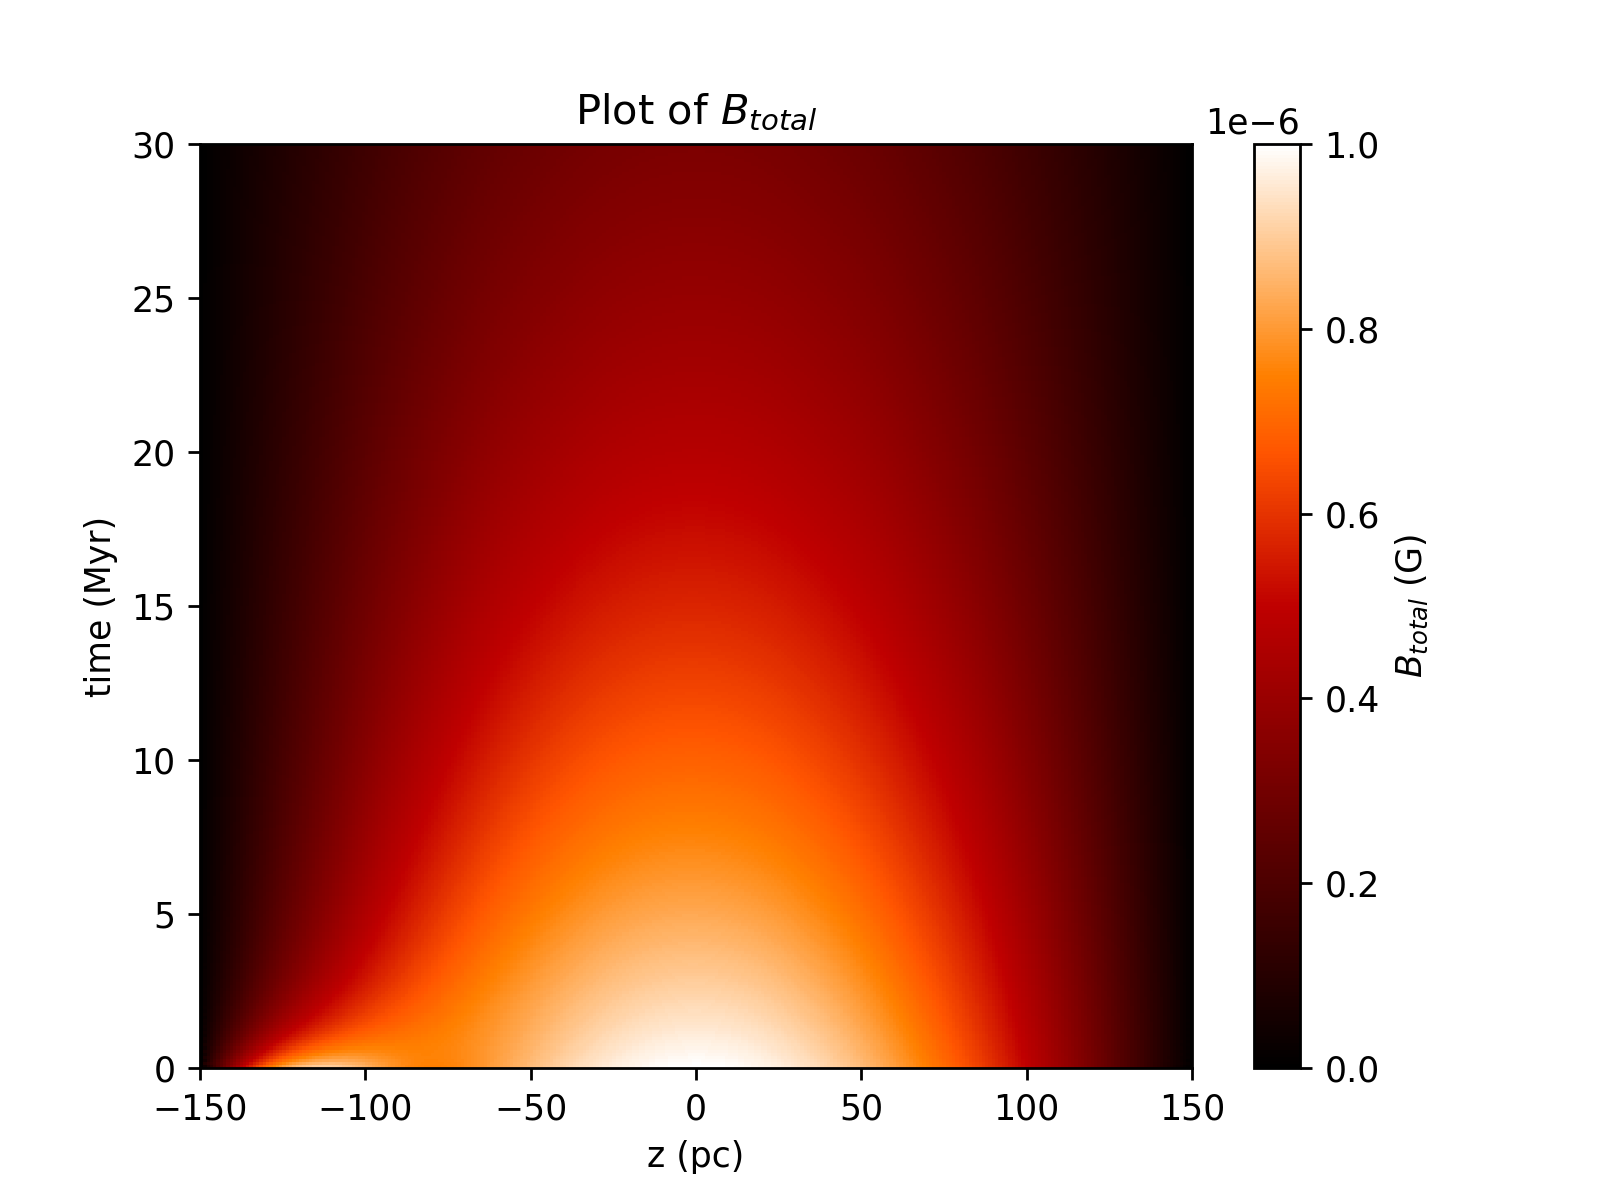

In [20]:
fig1=plt.figure(dpi=250)
plt.imshow(B_total, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$B_{total}$ (G)')
plt.xlabel('z (pc)')
plt.ylabel('time (Myr)')
plt.title(r'Plot of $B_{total}$')
plt.savefig('images_sim/B_t12_heat.png')
plt.show()

In [21]:
create_ani(B_total[::5],z_val,t_val[::5],'animations/B_t12.gif',['z (pc)',r'$B_{tot}$ (G)'])

![Variation in Total B with time](animations/B_t12.gif?dummy=190)

Plotting pitch angle $P_b$ versus time

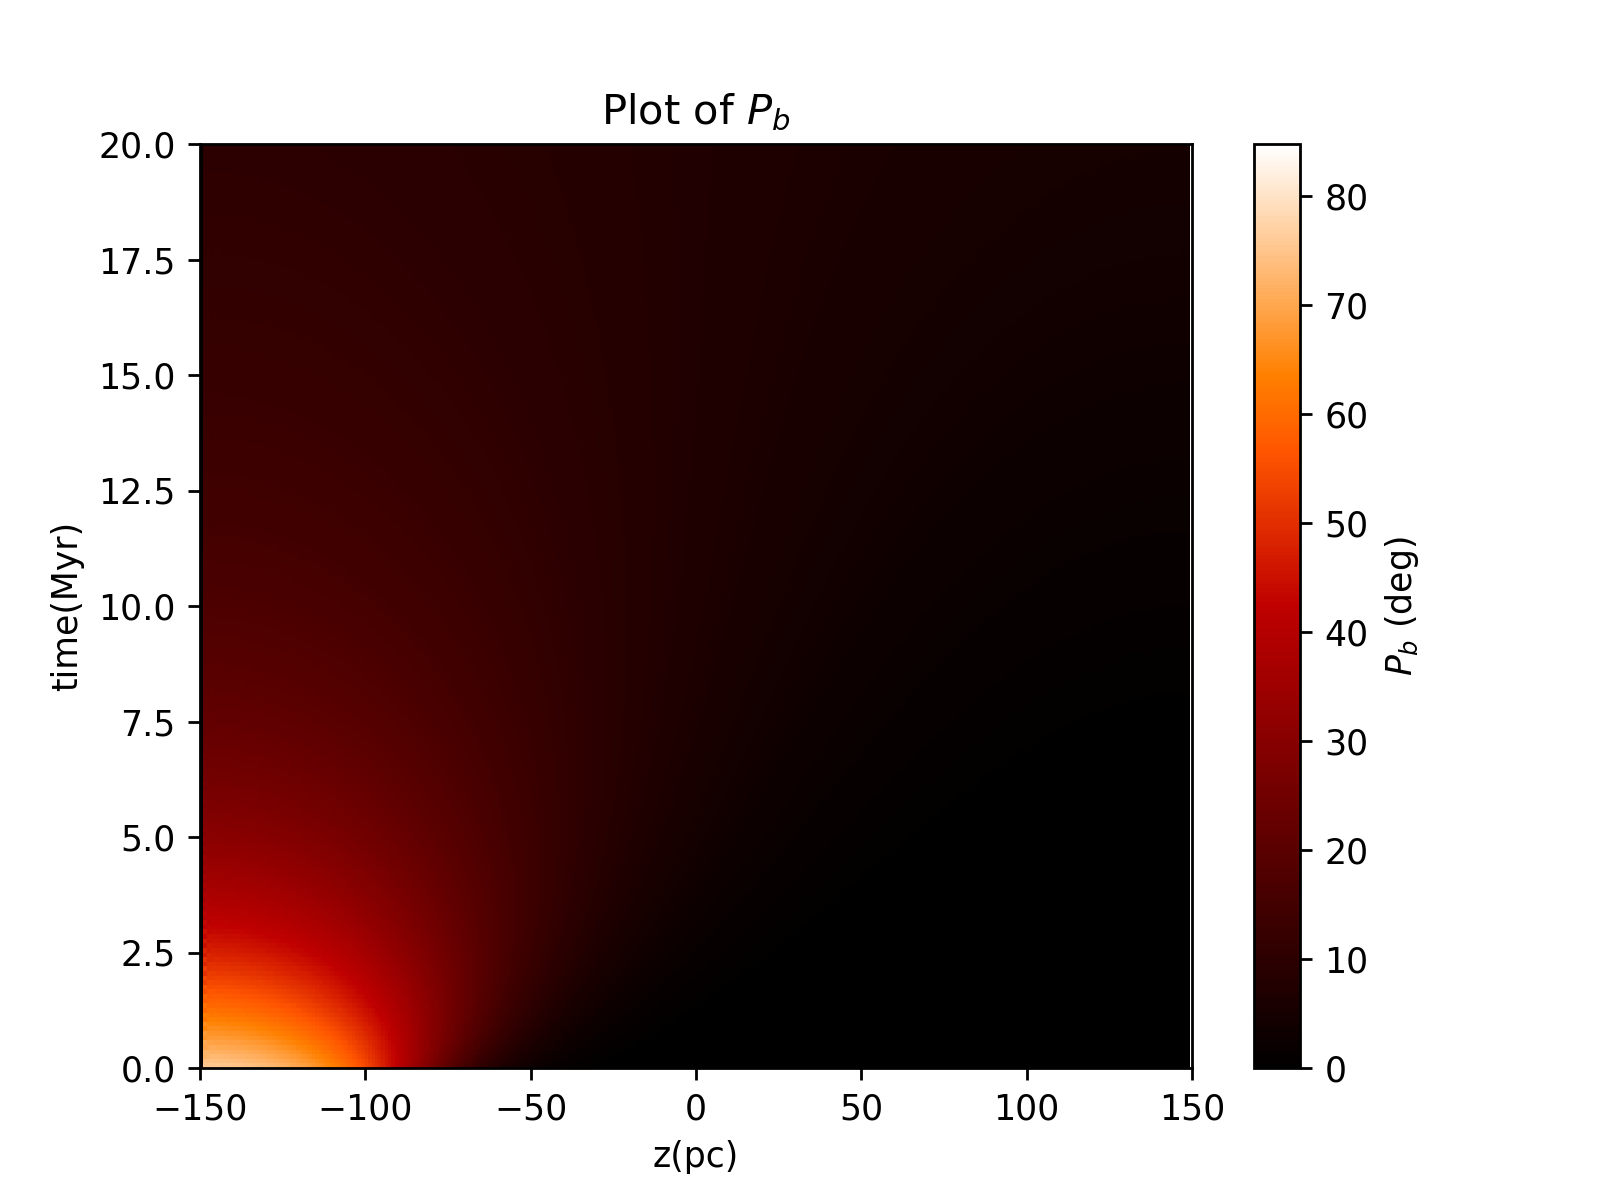

In [22]:
fig1=plt.figure(dpi=250)
plt.imshow(p_b, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$P_b$ (deg)')
plt.xlabel('z(pc)')
plt.ylabel('time(Myr)')
plt.title(r'Plot of $P_{b}$')
plt.ylim([0,20])
plt.savefig('images_sim/P_b12_heat.png')
plt.show()

In [23]:
create_ani(p_b[:][:,1:-1][::7],z_val[1:-1],t_val[::7],'animations/P_b12.gif',['z (pc)',r'$P_b$ (deg)'])

![Variation of Pitch angle with time](animations/P_b12.gif?dummy=51783)

# PART 2

## Code

Importing Packages

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import plotly.graph_objects as go
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")
fig_s=800

### Defining Functions

Defining the Crank Nicolson Function for special case

In [25]:
def mod_crank_nicolson(z,B0_r, dt, T,eta,alpha,Omega,q,B0_phi=None):
    """
    u0: initial condition, a function of x
    dx: space step size
    dt: time step size
    T: total time upto which integration is to be done
    """
    if B0_phi is None:
        B0_phi=np.zeros(B0_r.shape)
    # Spatial grid
    G=len(B0_r)
    H=int(T/dt)

    # Coefficients for the matrix A and B
    rho = eta*dt/(2*dz**2)
    mu=dt/(2*dz)*alpha
    # print(alpha*mu)
    sigma =-0.5*np.gradient(alpha,z)+mu
    U = np.zeros((2*G, H))
        
    P = np.zeros((2*G, 2*G))
    Q = np.zeros((2*G, 2*G))
    for i in range(G):
        P[i, i] = 1+2*rho
        P[i, i+G] = -sigma[i]
        P[i+G, i] = q*Omega*dt/2
        P[i+G, i+G] = 1+2*rho
        Q[i, i] = 1-2*rho
        Q[i, i+G] = sigma[i]
        Q[i+G, i] = -q*Omega*dt/2
        Q[i+G, i+G] = 1-2*rho
        U[i, 0] = B0_r[i]
        U[G+i, 0] = B0_phi[i]
        if i<G-1:
            P[i, i+1] = -rho
            P[i, i+G+1] = mu[i]
            P[i+G, i+G+1] = -rho
            P[i+1, i] = -rho
            P[i+G+1, i+G] = -rho
            Q[i, i+1] = rho
            Q[i, i+G+1] = -mu[i]
            Q[i+G, i+G+1] = rho
            Q[i+1, i] = rho
            Q[i+G+1, i+G] = rho
    # Iterating for each time step
    for n in range(1,H):
        U[:, n] = np.dot(np.linalg.inv(P), np.dot(Q, U[:, n - 1]))
    return U[:G, :].T, U[G:, :].T

In [26]:
def bisection(f, a, b, eps):
    counter = 1
    COUNT = []
    VAL = []
    if f(a)*f(b) == 0.0:
        if f(a)==0.0:
            return a
        else:
            return b

    c = (a+b)/2
    while np.abs(f(c)) > eps: # checking if the accuracy is achieved

        c = (a+b)/2
        if (f(a)*f(c)) <= 0.0: # Check if the root is properly bracketted
            b = c
        else:
            a = c
        if counter > 100:
            print('Maximum iterations reached.')
            break
        counter += 1
        COUNT.append(counter)
        VAL.append(c)

    return c, COUNT, VAL

In [27]:
def c_dynamo(alpha_0):
    #Spatial resolution and spatial domain
    z_min = -150 #pc
    z_max = 150 #pc
    dz = 1 #pc
    #Array of all spatial points
    z_val = np.arange(z_min, z_max + dz, dz)
    #Time resolution and time upto which integration is to be done
    t_f=400 #Myr
    dt=0.4 #Myr

    t_val = np.arange(0, t_f, dt)
    #Initial condition
    B0_R=(1e-6)*np.sin((np.pi*(z_val-z_min)/(2*z_max)))
    B0_R[-1]=0
    #Diffusion parameter
    eta=1e26*((3.24078e-19)**2)/(3.1710e-14)#1e26 cm^2/s converted to pc^2/Myr
    # alpha_0= 0.001*1.023#1km/s converted to pc/Myr
    alpha =alpha_0*np.sin(np.pi*(z_val-z_min)/(2*z_max)/2)    
    Omega = 30*1.023   #30km/s converted to pc/Myr
    q = 1
    # Solve the diffusion equation in radial direction
    B_R,B_PHI = mod_crank_nicolson(z_val,B0_R, dt, t_f,eta,alpha,Omega,q,)
    B_total,_=b_total_pitch(B_R,B_PHI)
    gamma=decay_factor(B_total[:,int(B_total.shape[1]/2)],t_val,pl=1)

    return gamma


### Applying specific Boundary Conditions

### 1) $B_{0r}=10^{-6}\left\{sin\left(\pi\frac{z-z_{min}}{z_{max}}\right)\right\} G$
### $\:\:\:$    Dynamo number=0.966

Boundary conditions resolution and other parameters

In [105]:
#Spatial resolution and spatial domain
z_min = -150 #pc
z_max = 150 #pc
dz = 1 #pc
#Array of all spatial points
z_val = np.arange(z_min, z_max + dz, dz)
#Time resolution and time upto which integration is to be done
t_f=400 #Myr
dt=0.4 #Myr

t_val = np.arange(0, t_f, dt)
#Initial condition
B0_R=(1e-6)*np.sin((np.pi*(z_val-z_min)/(2*z_max)))
B0_R[-1]=0
#Diffusion parameter
eta=1e26*((3.24078e-19)**2)/(3.1710e-14)#1e26 cm^2/s converted to pc^2/Myr
alpha_0= 0.001*1.023#1km/s converted to pc/Myr
alpha =alpha_0*np.sin(np.pi*(z_val-z_min)/(2*z_max)/2)    
Omega = 30*1.023   #30km/s converted to pc/Myr
q = 1
print(f'Eta:{eta} , Omega:{Omega}')
print(f'Dynamo number:{alpha_0*Omega*(150**3)/eta**2}')

Eta:331.2095556102176 , Omega:30.689999999999998
Dynamo number:0.9659187208249902


Plotting seed magnetic field

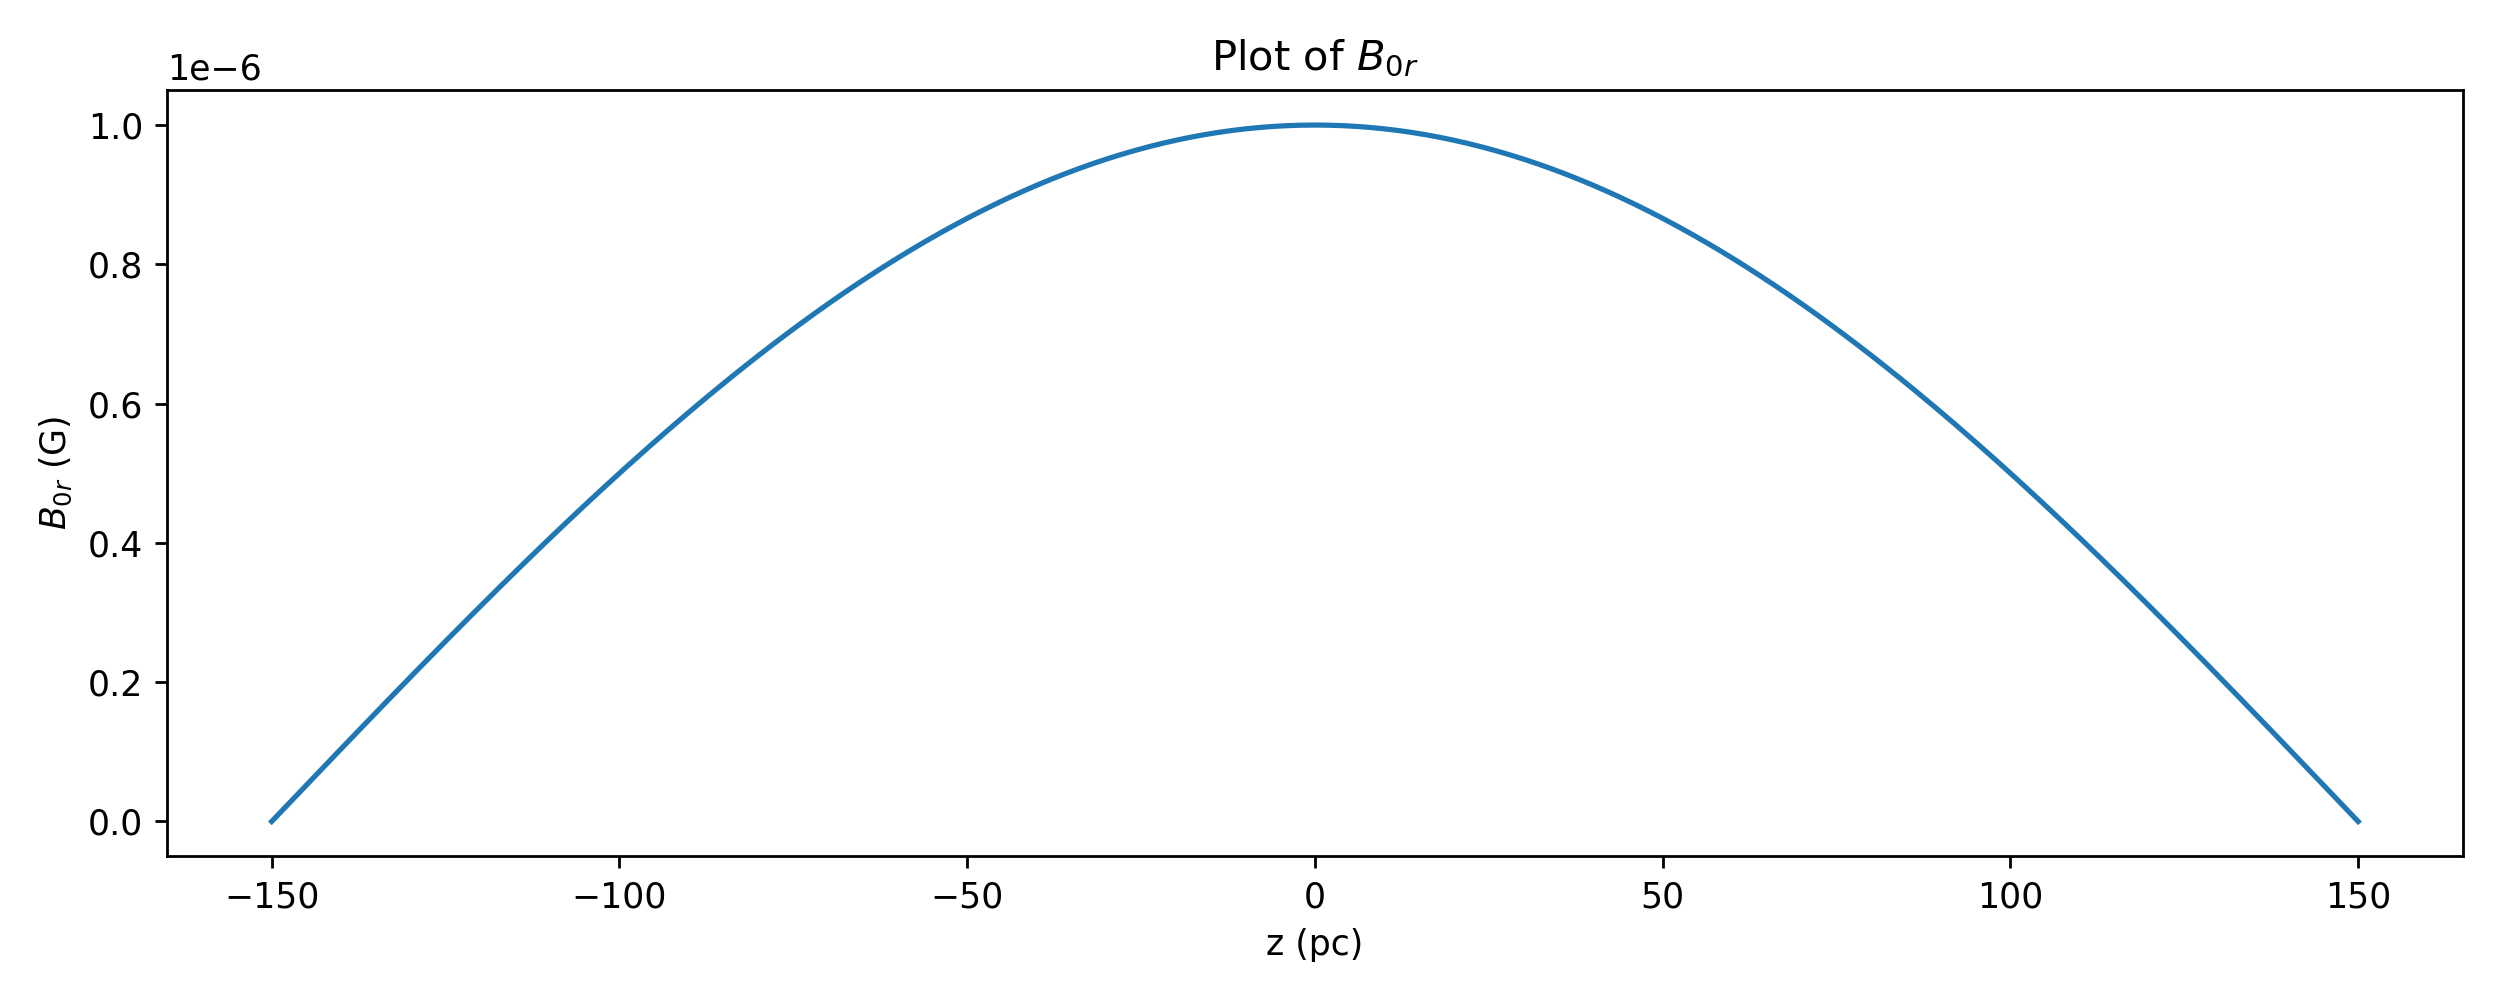

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=250)

# Plot of B0_R
axs.plot(z_val, B0_R)
axs.set_xlabel('z (pc)')
axs.set_ylabel(r'$B_{0r}$ (G)')
axs.set_title(r'Plot of $B_{0r}$')


plt.tight_layout()
plt.savefig('images_sim/seed_field21.png')
plt.show()

Plotting variation of $B_{r}$ with time

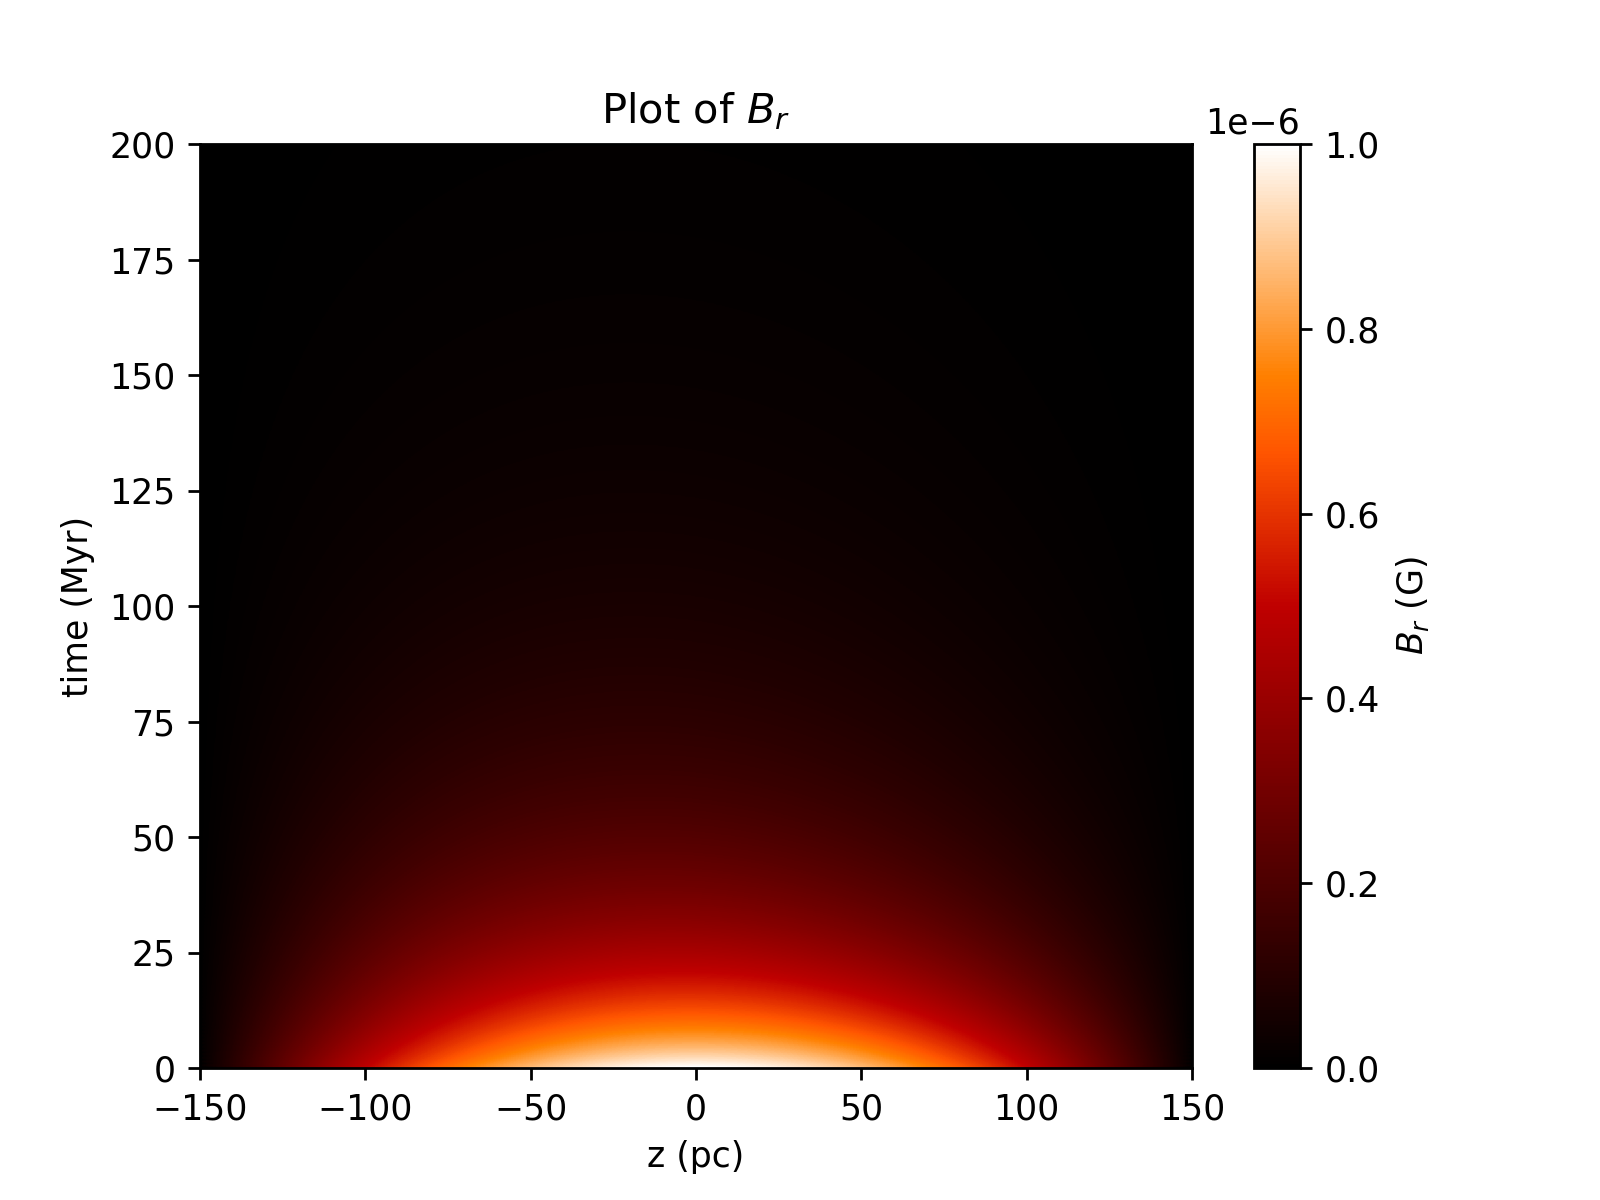

In [106]:
B_R,B_PHI = mod_crank_nicolson(z_val,B0_R, dt, t_f,eta,alpha,Omega,q,)
fig1=plt.figure(dpi=250)
plt.imshow(B_R, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$B_{r}$ (G)')
plt.xlabel('z (pc)')
plt.ylabel('time (Myr)')
plt.title(r'Plot of $B_{r}$')
plt.ylim([0,200])
plt.savefig('images_sim/B_r21_heat.png')
plt.show()

In [31]:
create_ani(B_R[:][:,1:-1][::1],z_val[1:-1],t_val[::10],'animations/B_r21.gif',['z (pc)',r'$B_r$ (G)'])

![B_r animation](animations/B_r21.gif?dummy=11113)

Plotting variation of $B_{\phi}$ with time

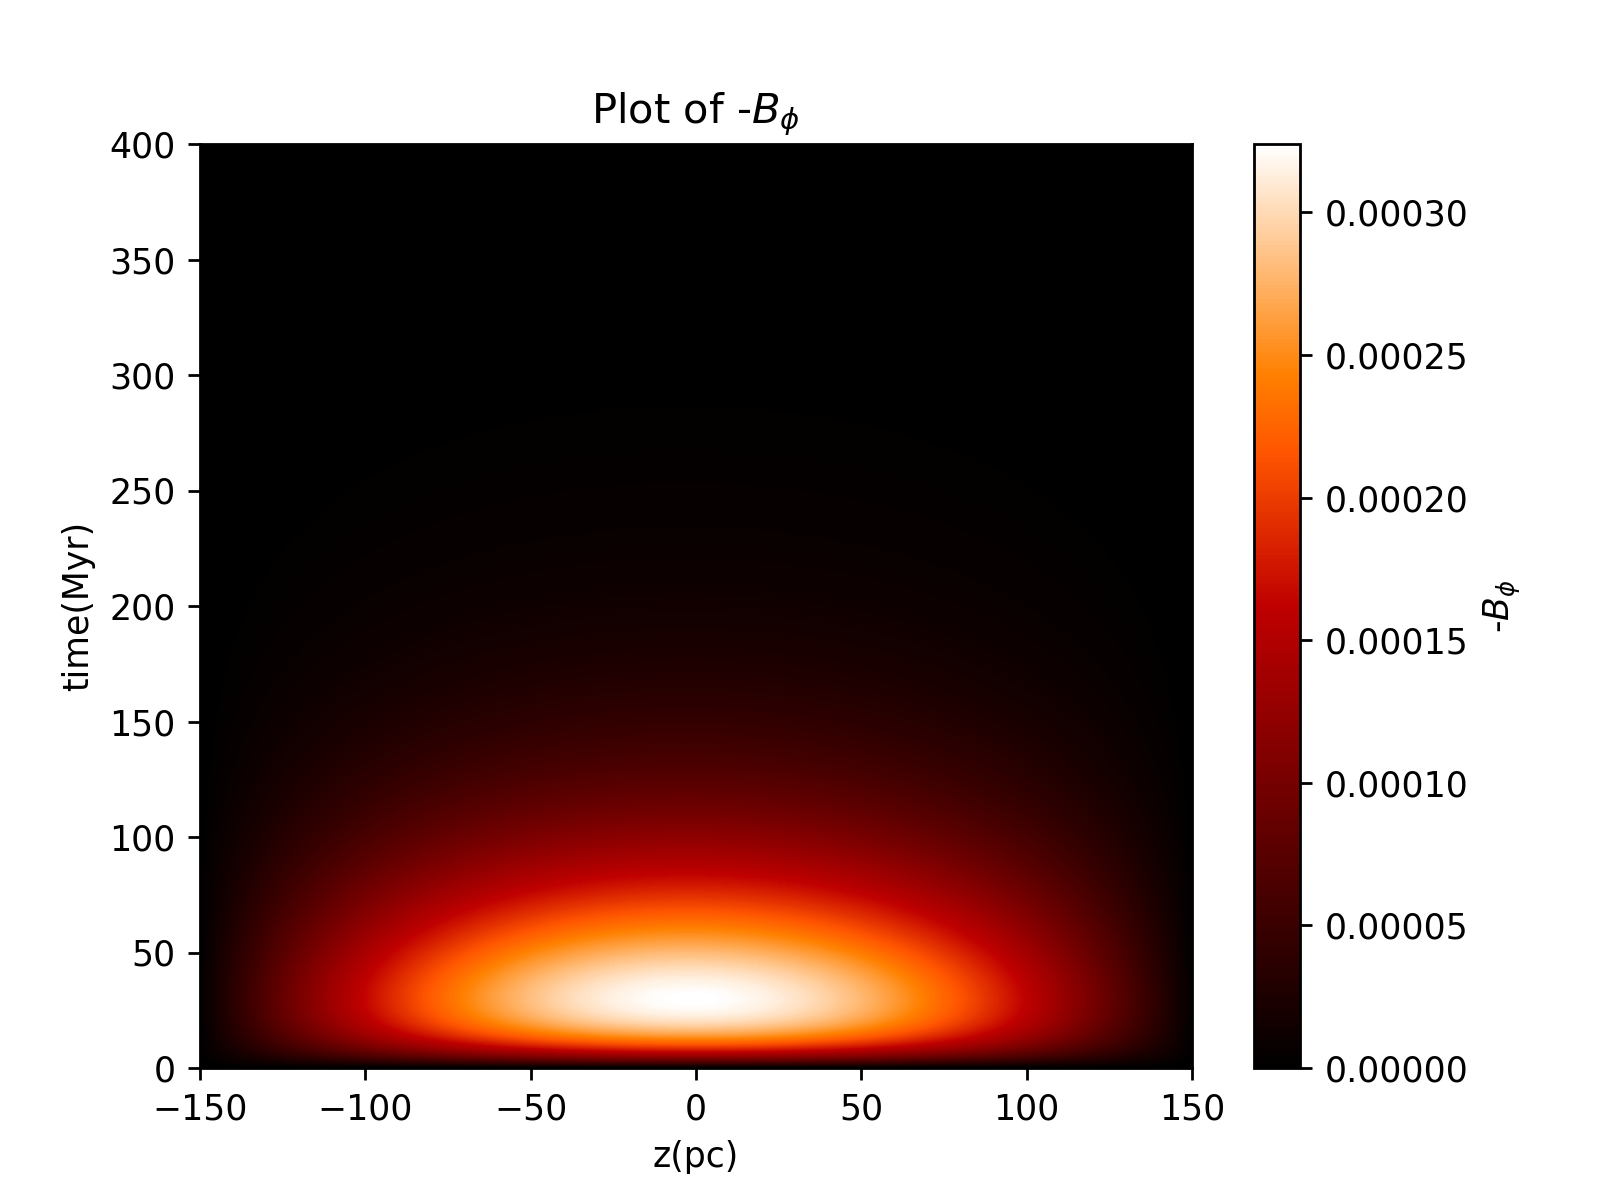

In [32]:
fig1=plt.figure(dpi=250)
plt.imshow(-B_PHI, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'-$B_{\phi}$')
plt.xlabel('z(pc)')
plt.ylabel('time(Myr)')
plt.title(r'Plot of -$B_{\phi}$')
plt.savefig('images_sim/B_phi21_heat.png')
plt.show()

In [33]:
create_ani(B_PHI[:][:,1:-1][::1],z_val[1:-1],t_val[::5],'animations/B_phi21.gif',['z (pc)',r'$B_{phi}$ (G)'])

![B_phi animation](animations/B_phi21.gif?dummy=1113)

Calculating the decay rate $\gamma$ and $B_{total}$

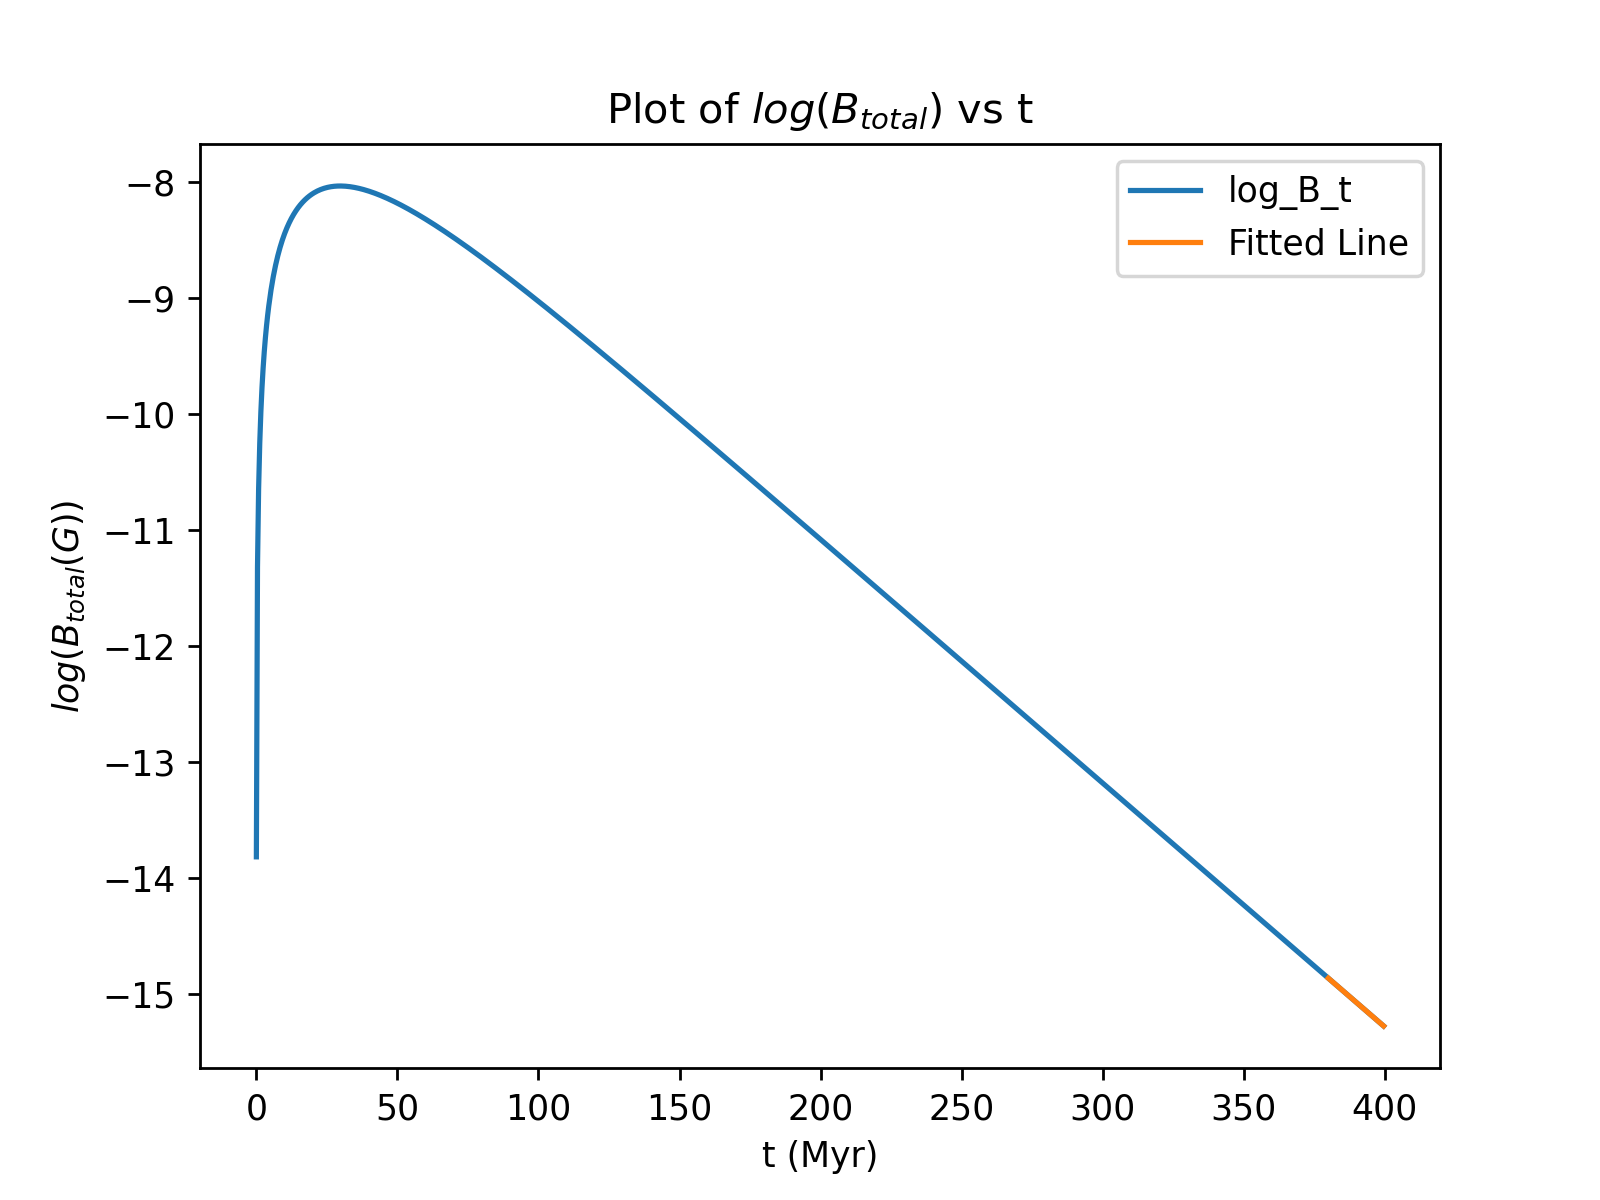

Decay factor gamma for B  0.021017236405159335


In [107]:
B_total,p_b=b_total_pitch(B_R,B_PHI)
gamma=decay_factor(B_total[:,int(B_total.shape[1]/2)],t_val,q=21)
# plt.plot(t_val, np.log(B_total[:,50]), label='log_B_t')
plt.legend()

# Show the plot
# plt.show()
print("Decay factor gamma for B ",-gamma)

Ploting variation of $B_{total}$ with time

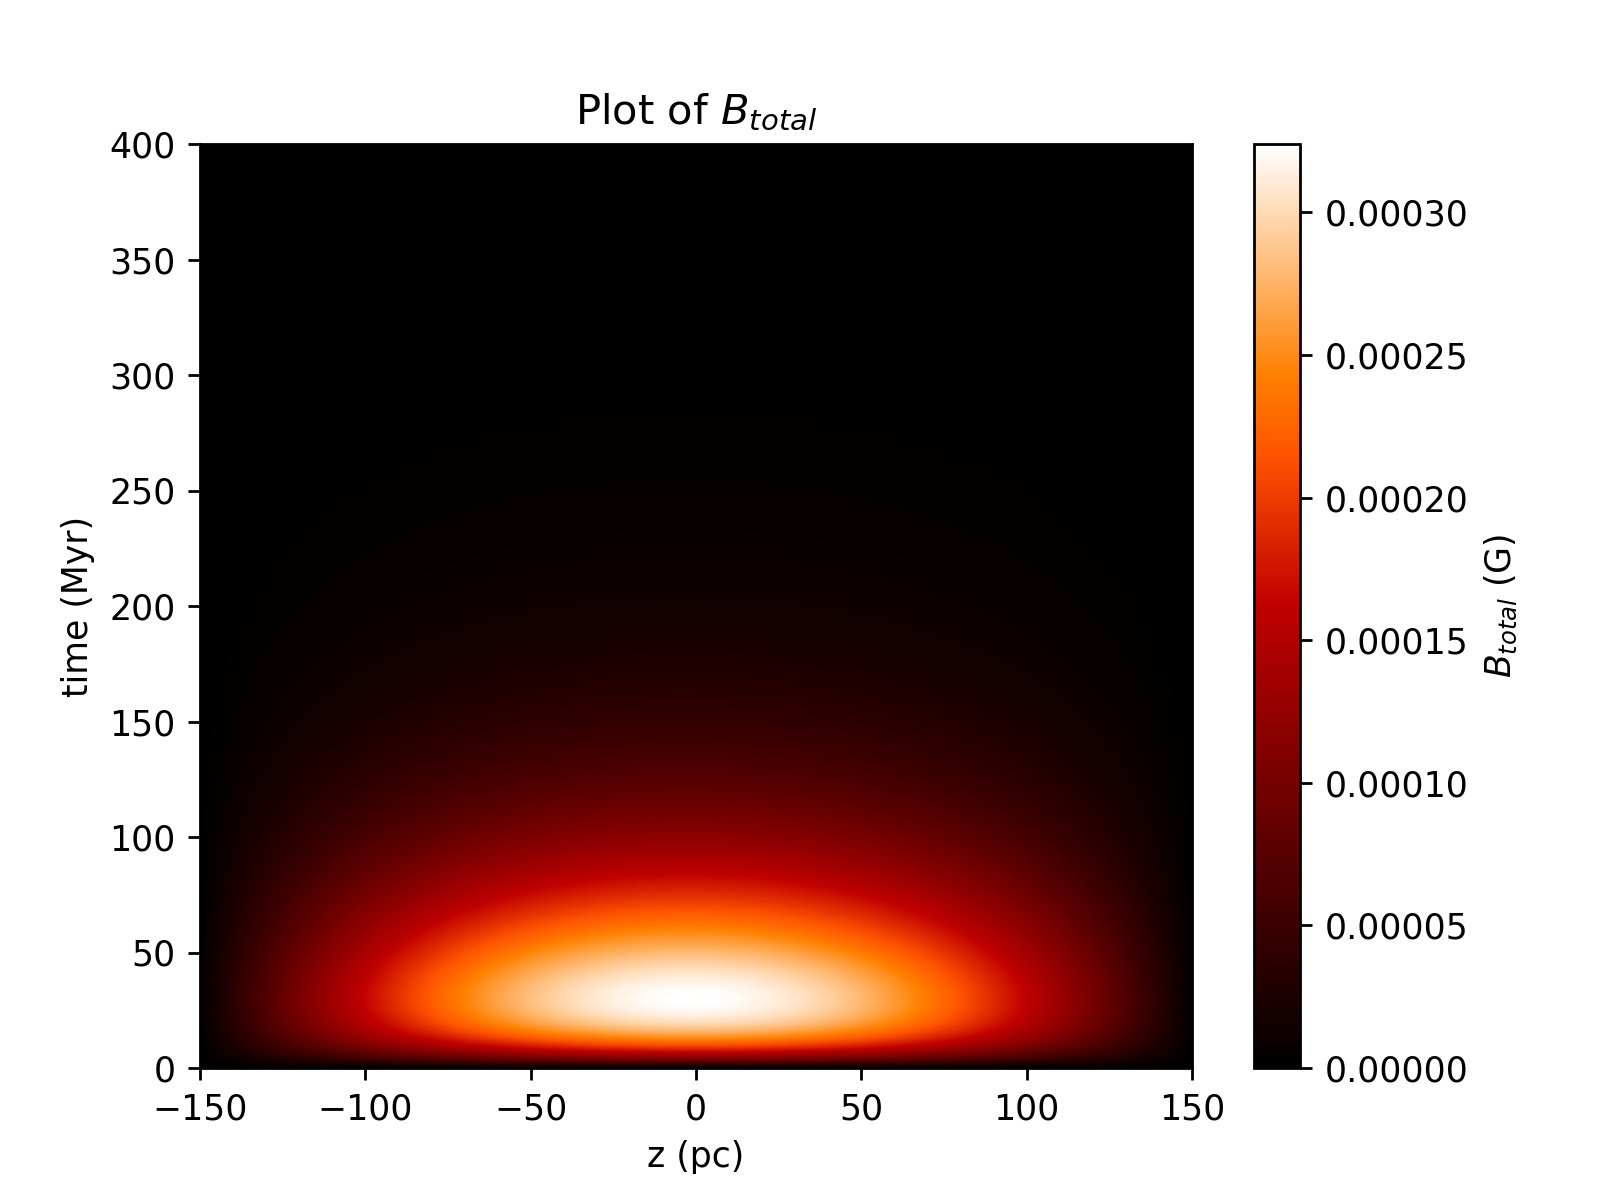

In [35]:
fig1=plt.figure(dpi=250)
plt.imshow(B_total, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$B_{total}$ (G)')
plt.xlabel('z (pc)')
plt.ylabel('time (Myr)')
plt.title(r'Plot of $B_{total}$')
plt.savefig('images_sim/B_t21_heat.png')
plt.show()

In [36]:
create_ani(B_total[::5],z_val,t_val[::5],'animations/B_t21.gif',['z (pc)',r'$B_{tot}$ (G)'])

![Variation in Total B with time](animations/B_t21.gif?dummy=99775)

Plotting pitch angle $P_b$ versus time

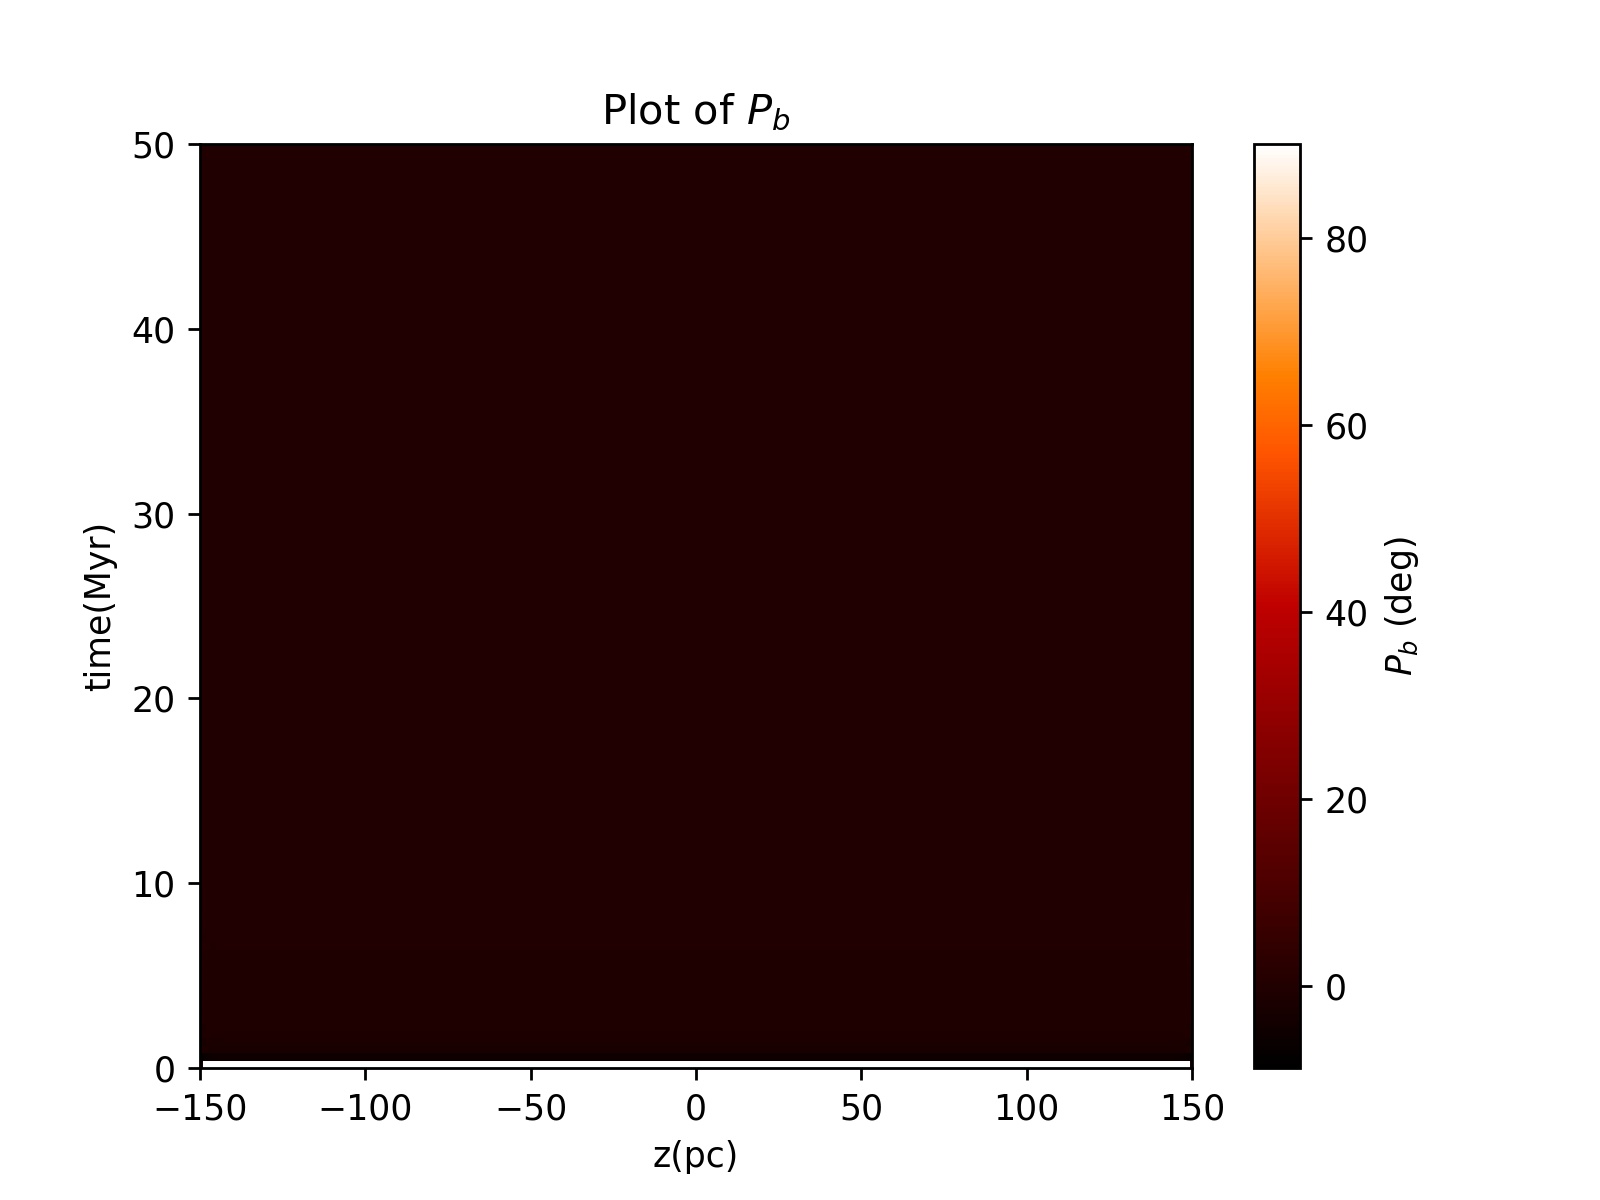

In [108]:
fig1=plt.figure(dpi=250)
plt.imshow(p_b, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$P_b$ (deg)')
plt.xlabel('z(pc)')
plt.ylabel('time(Myr)')
plt.ylim([0,50])
plt.title(r'Plot of $P_{b}$')
plt.savefig('images_sim/P_b21_heat.png')
plt.show()

In [39]:
create_ani(p_b[:][:,1:-1][::7],z_val[1:-1],t_val[::7],'animations/P_b21.gif',['z (pc)',r'$P_b$ (deg)'])

![Variation of Pitch angle with time](animations/P_b21.gif?dummy=1323)

### 2) $B_{0r}=10^{-6}\left\{sin\left(\pi\frac{z-z_{min}}{z_{max}}\right)\right\} G$
### $\:\:\:$    Dynamo number=9.66

Boundary conditions resolution and other parameters

In [40]:
#Spatial resolution and spatial domain
z_min = -150 #pc
z_max = 150 #pc
dz = 1 #pc
#Array of all spatial points
z_val = np.arange(z_min, z_max + dz, dz)
#Time resolution and time upto which integration is to be done
t_f=400 #Myr
dt=0.4 #Myr

t_val = np.arange(0, t_f, dt)
#Initial condition
B0_R=(1e-6)*np.sin((np.pi*(z_val-z_min)/(2*z_max)))
B0_R[-1]=0
#Diffusion parameter
eta=1e26*((3.24078e-19)**2)/(3.1710e-14)#1e26 cm^2/s converted to pc^2/Myr
alpha_0= 0.01*1.023#1km/s converted to pc/Myr
alpha =alpha_0*np.sin(np.pi*(z_val-z_min)/(2*z_max)/2)    
Omega = 30*1.023   #30km/s converted to pc/Myr
q = 1
print(f'Eta:{eta} , Omega:{Omega}')
print(f'Dynamo number:{alpha_0*Omega*(150**3)/eta**2}')

Eta:331.2095556102176 , Omega:30.689999999999998
Dynamo number:9.659187208249902


Plotting seed magnetic field

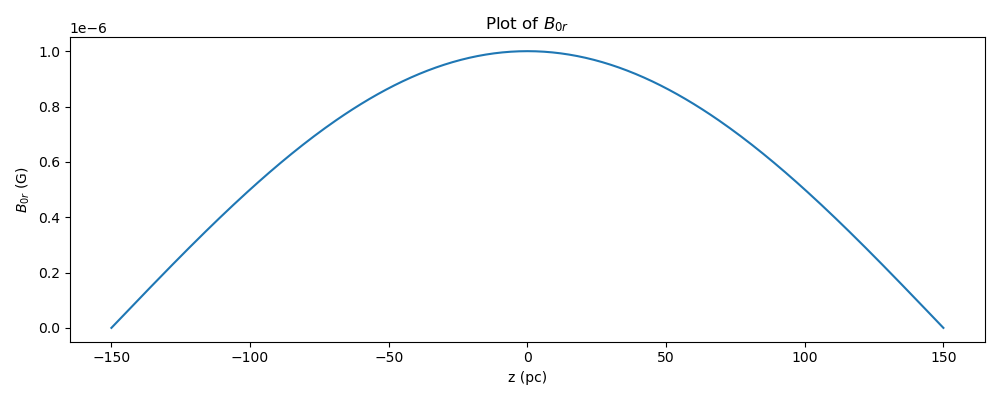

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

# Plot of B0_R
axs.plot(z_val, B0_R)
axs.set_xlabel('z (pc)')
axs.set_ylabel(r'$B_{0r}$ (G)')
axs.set_title(r'Plot of $B_{0r}$')

plt.savefig('images_sim/seed_field22.png')
plt.tight_layout()
plt.show()

Plotting variation of $B_{r}$ with time

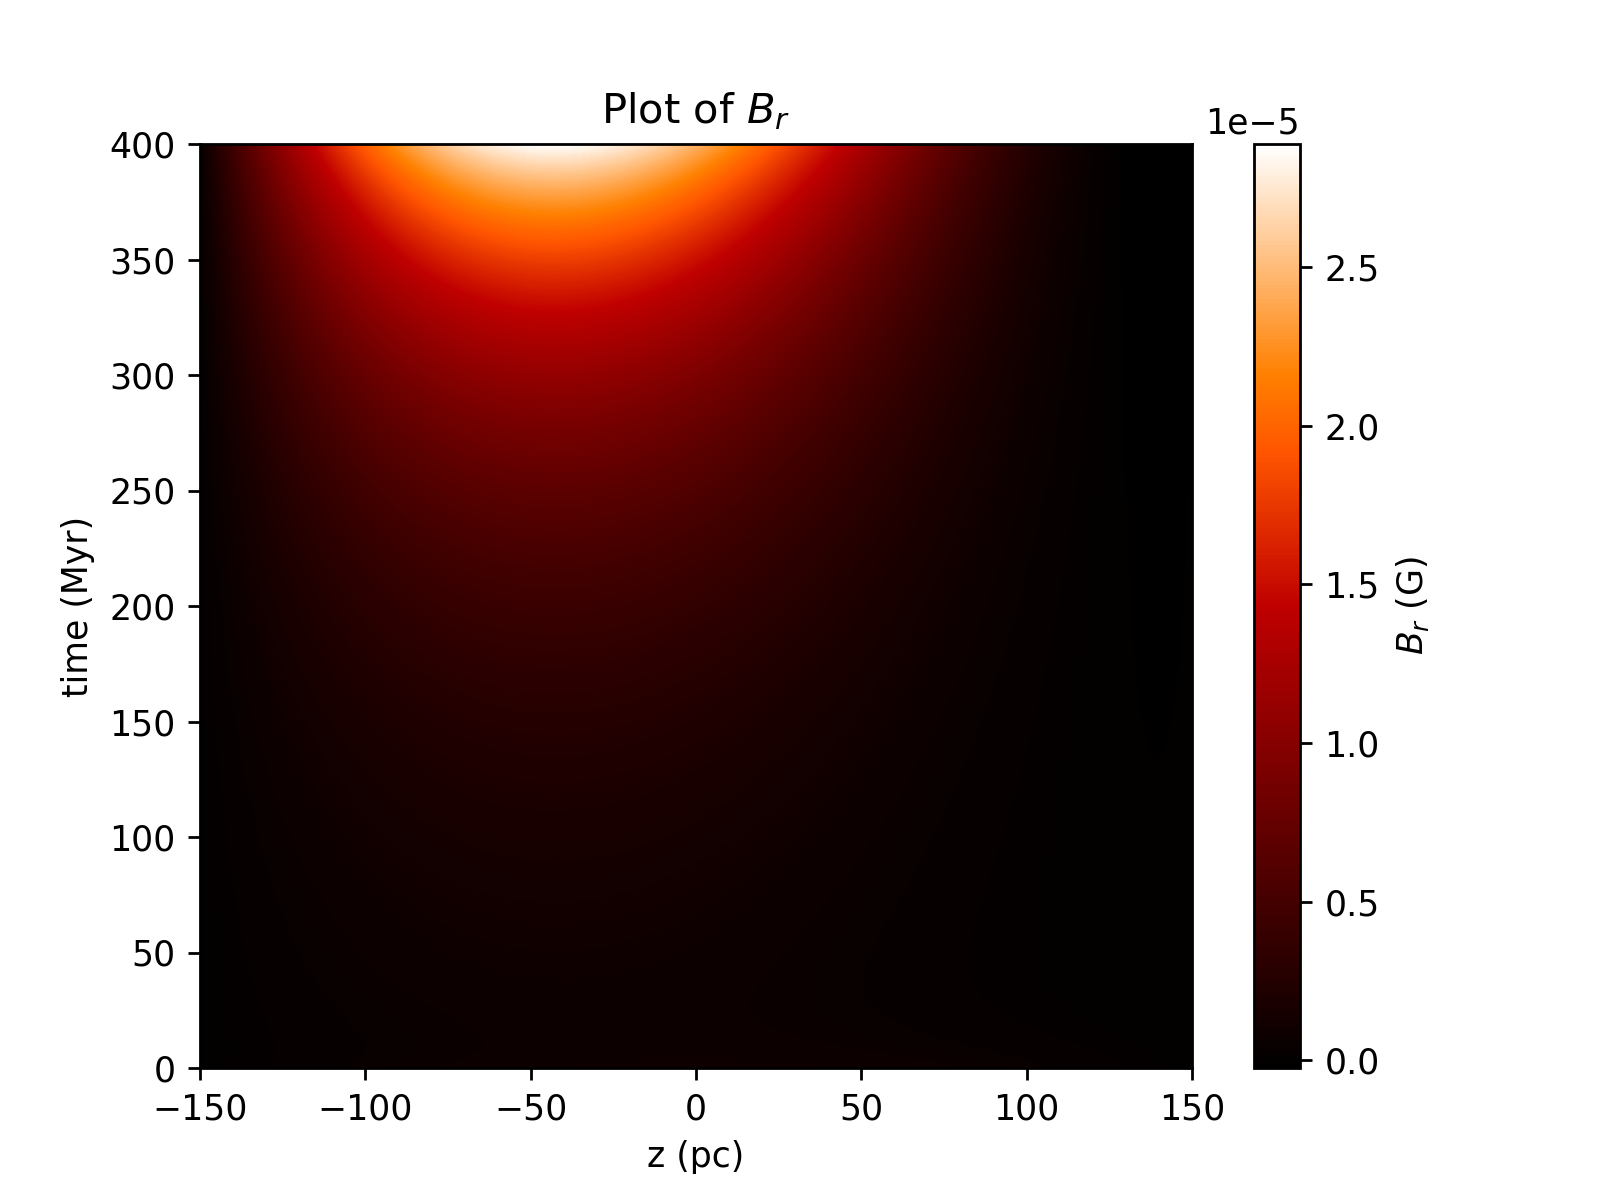

In [42]:
B_R,B_PHI = mod_crank_nicolson(z_val,B0_R, dt, t_f,eta,alpha,Omega,q,)
fig1=plt.figure(dpi=250)
plt.imshow(B_R, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$B_{r}$ (G)')
plt.xlabel('z (pc)')
plt.ylabel('time (Myr)')
plt.title(r'Plot of $B_{r}$')
plt.savefig('images_sim/B_r22_heat.png')
plt.show()

In [43]:
create_ani(B_R[:][:,1:-1][::1],z_val[1:-1],t_val[::10],'animations/B_r22.gif',['z (pc)',r'$B_r$ (G)'])

![B_r animation](animations/B_r22.gif?dummy=192117)

Plotting variation of $B_{\phi}$ with time

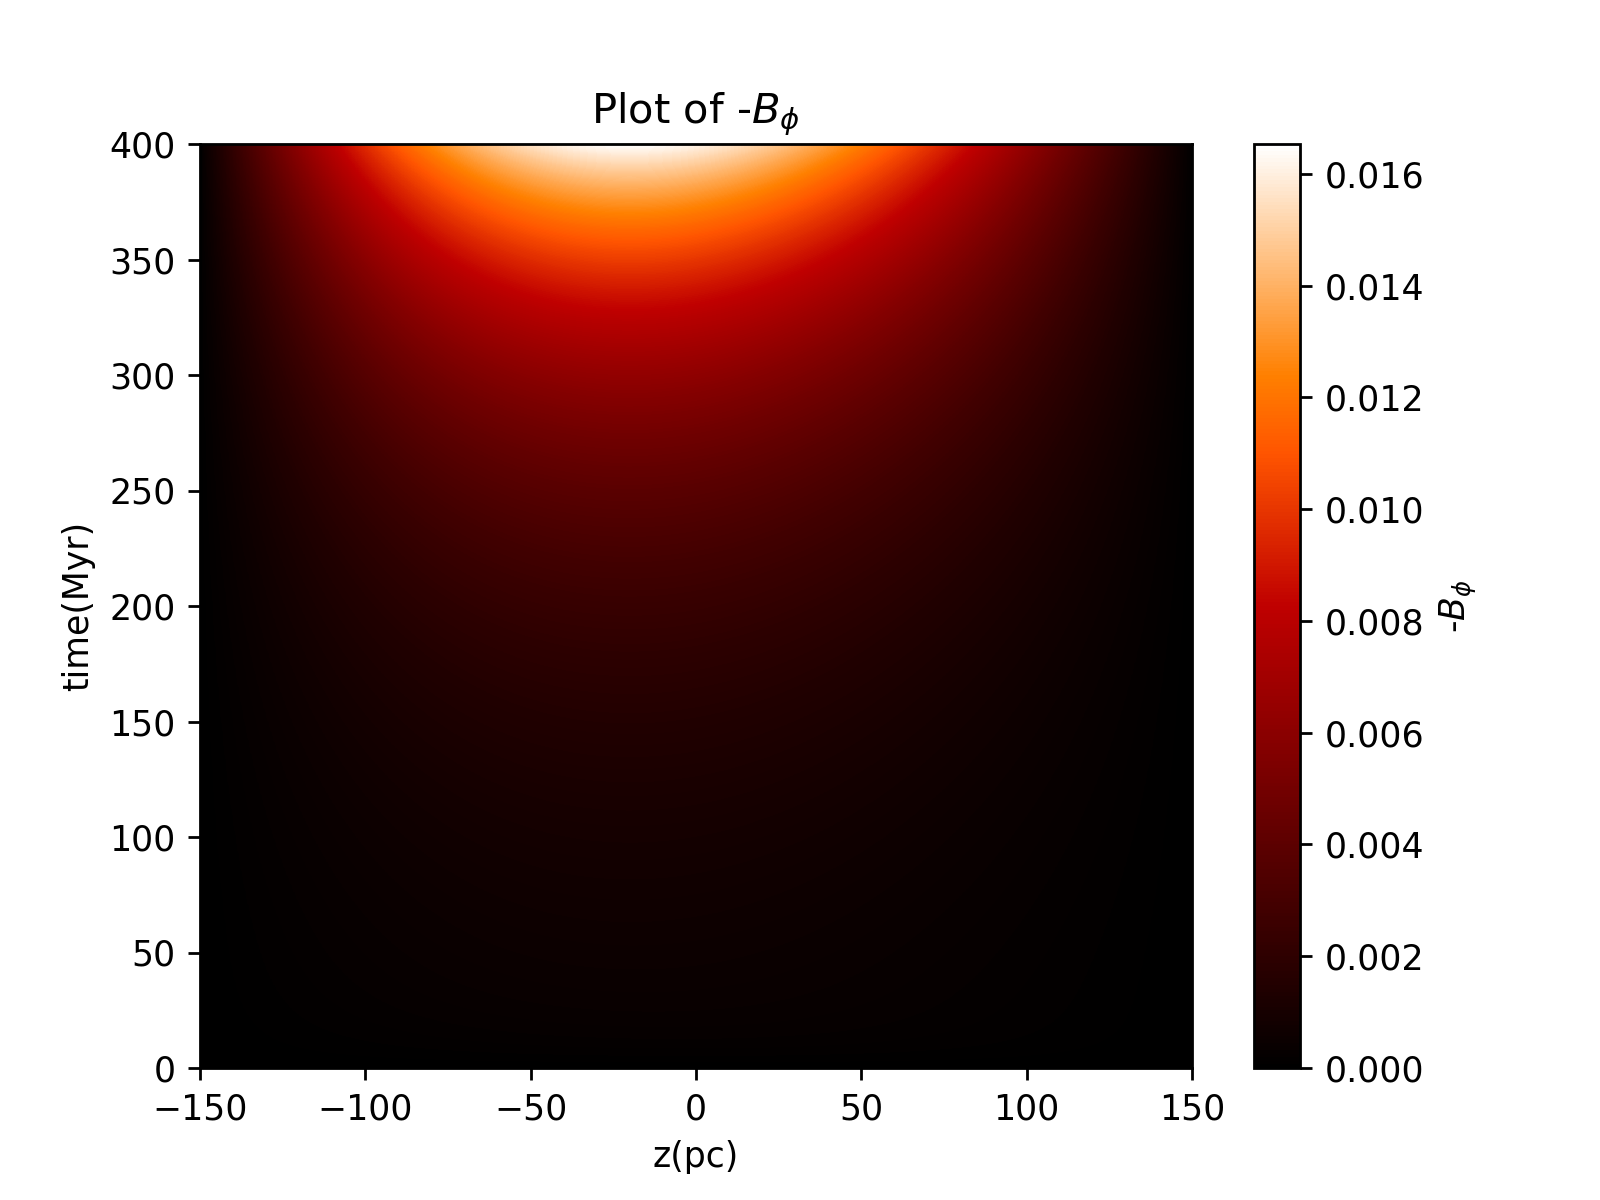

In [44]:
fig1=plt.figure(dpi=250)
plt.imshow(-B_PHI, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'-$B_{\phi}$')
plt.xlabel('z(pc)')
plt.ylabel('time(Myr)')
plt.title(r'Plot of -$B_{\phi}$')
plt.savefig('images_sim/B_phi22_heat.png')
plt.show()

In [45]:
create_ani(B_PHI[:][:,1:-1][::1],z_val[1:-1],t_val[::5],'animations/B_phi22.gif',['z (pc)',r'$B_{phi}$ (G)'])

![B_phi animation](animations/B_phi22.gif?dummy=1133)

Calculating the decay rate $\gamma$ and $B_{total}$

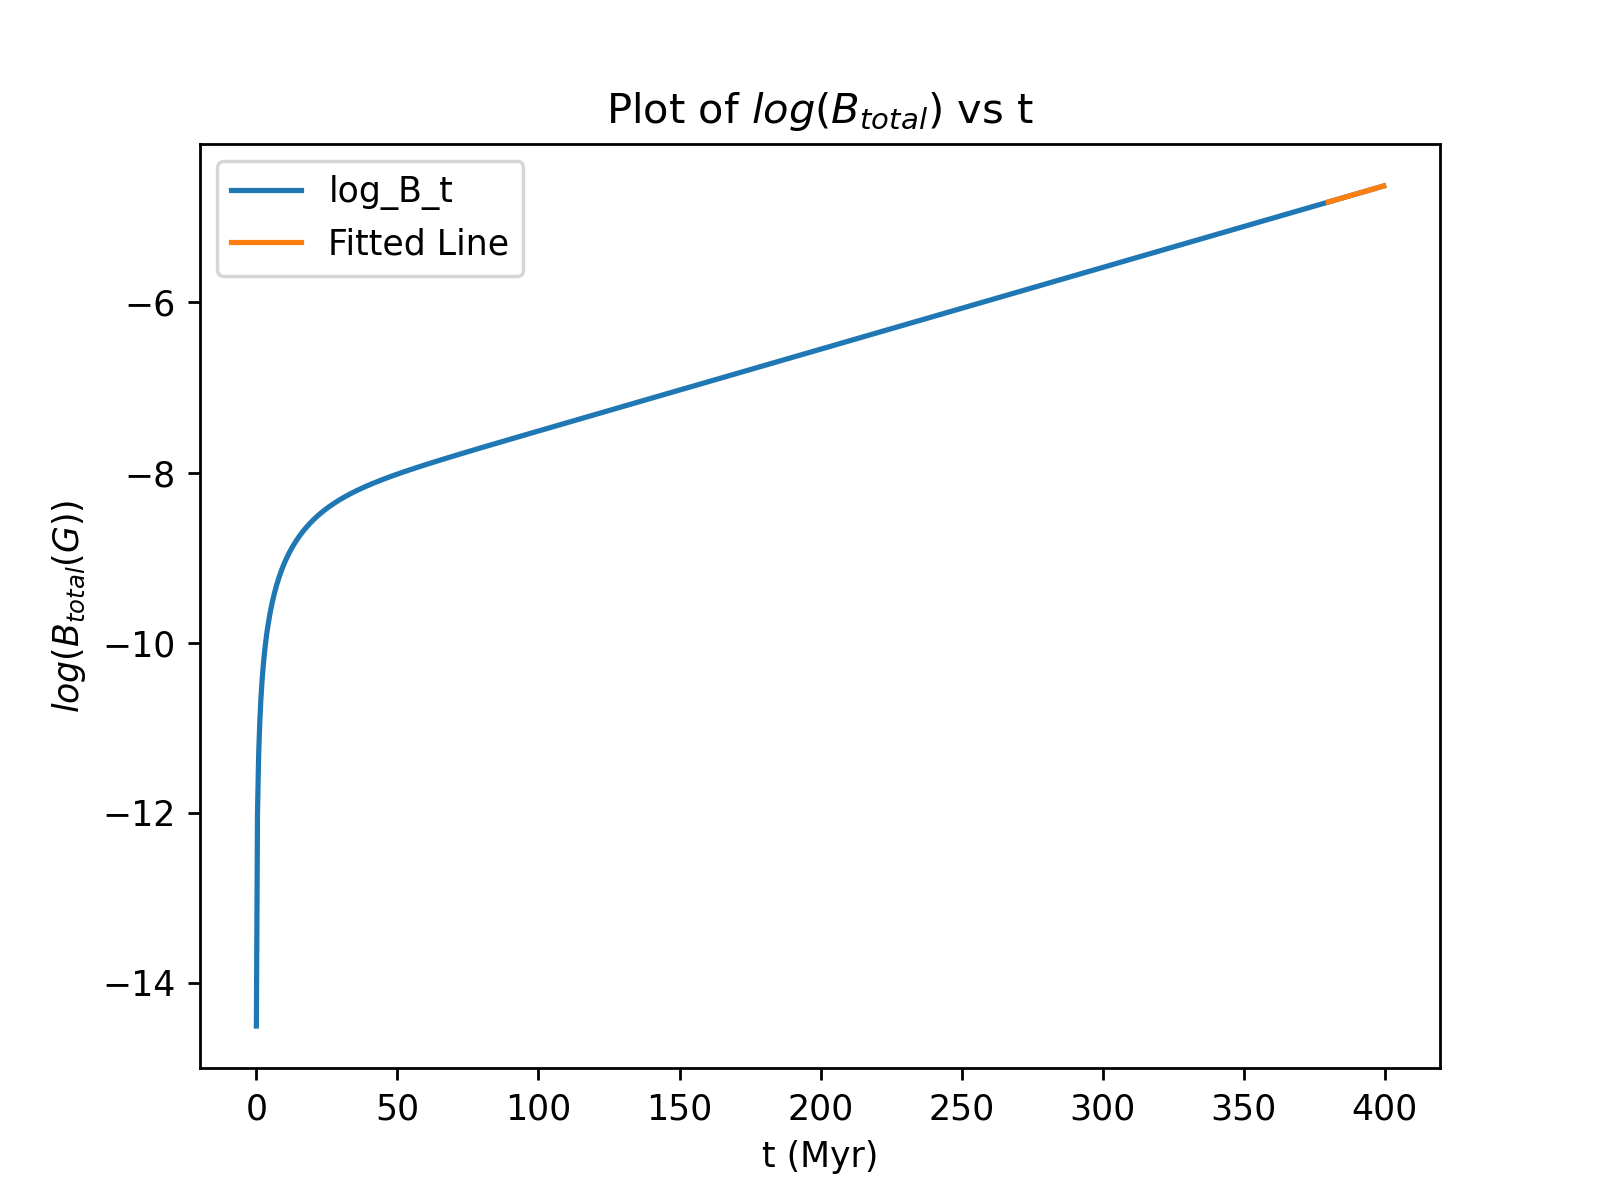

Decay factor gamma for B  -0.009614846443751936


In [46]:
B_total,p_b=b_total_pitch(B_R,B_PHI)
gamma=decay_factor(B_total[:,50],t_val,q=22)
# plt.plot(t_val, np.log(B_total[:,50]), label='log_B_t')
plt.legend()
print("Decay factor gamma for B ",-gamma)

Ploting variation of $B_{total}$ with time

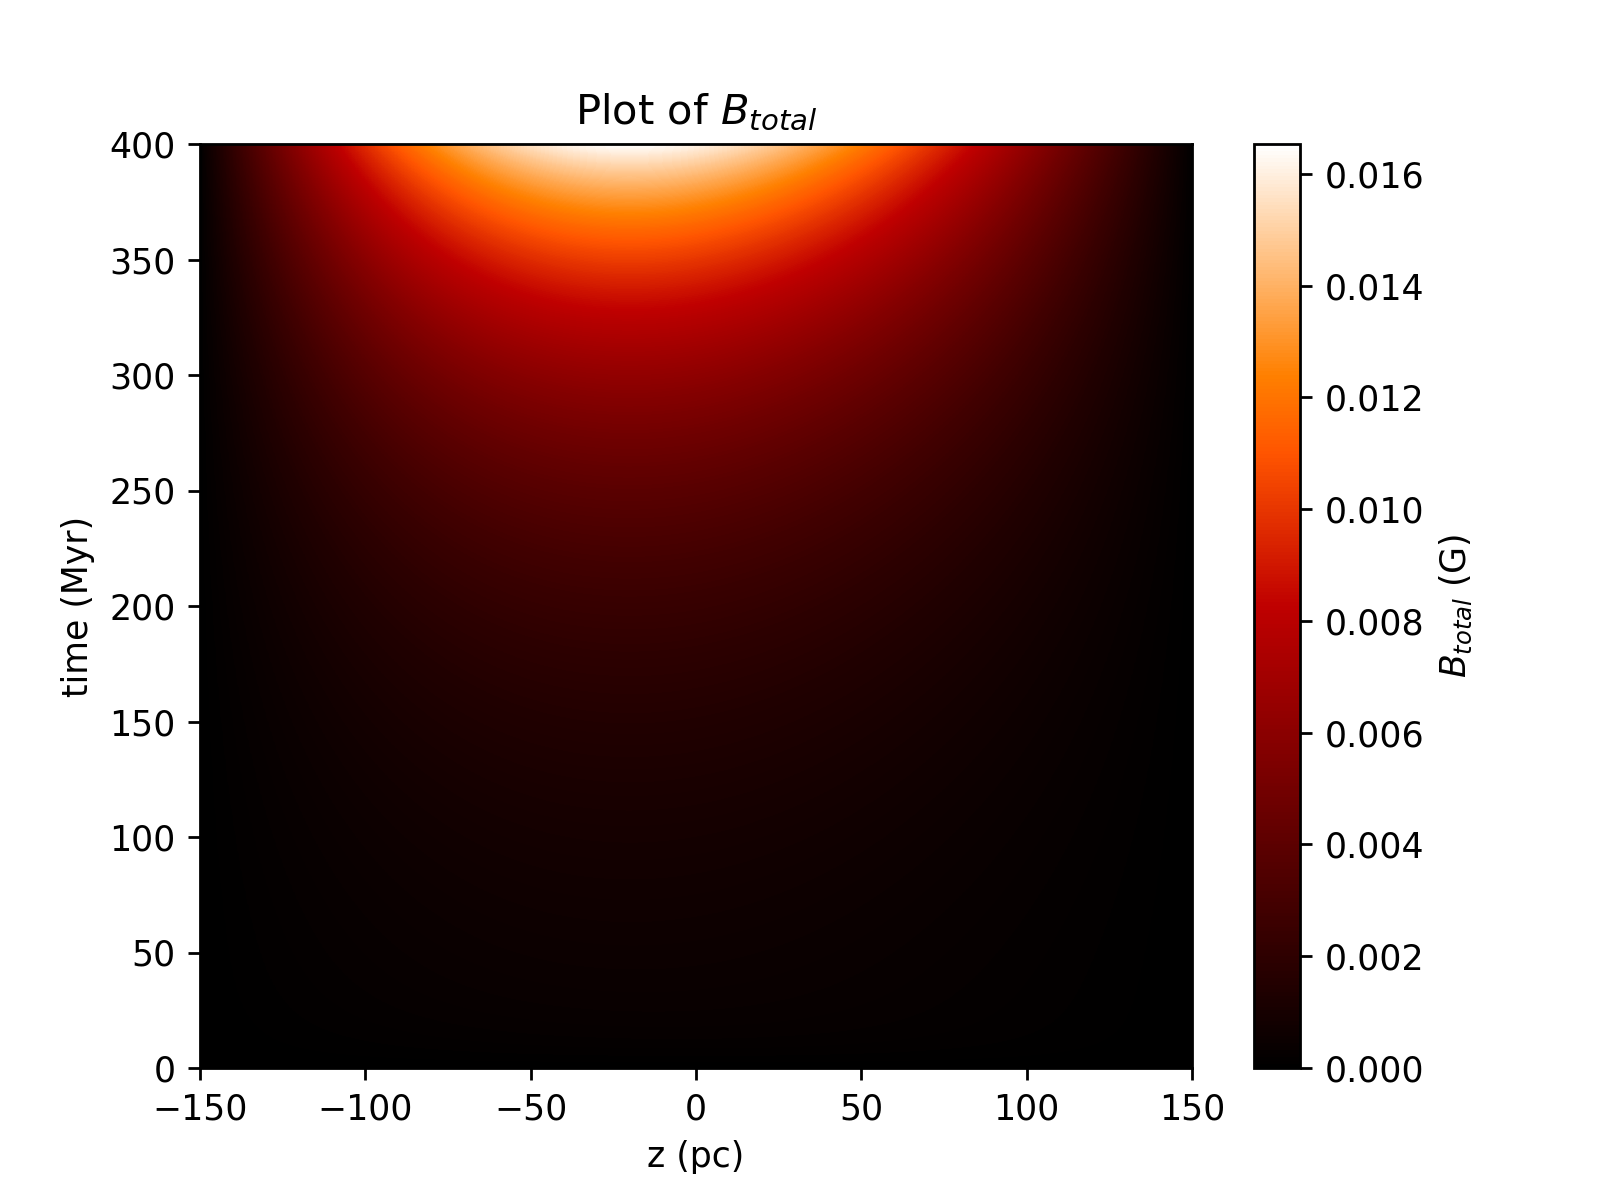

In [47]:
fig1=plt.figure(dpi=250)
plt.imshow(B_total, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$B_{total}$ (G)')
plt.xlabel('z (pc)')
plt.ylabel('time (Myr)')
plt.title(r'Plot of $B_{total}$')
plt.savefig('images_sim/B_t22_heat.png')
plt.show()

In [48]:
create_ani(B_total[::5],z_val,t_val[::5],'animations/B_t22.gif',['z (pc)',r'$B_{tot}$ (G)'])

![Variation in Total B with time](animations/B_t22.gif?dummy=34873)

Plotting pitch angle $P_b$ versus time

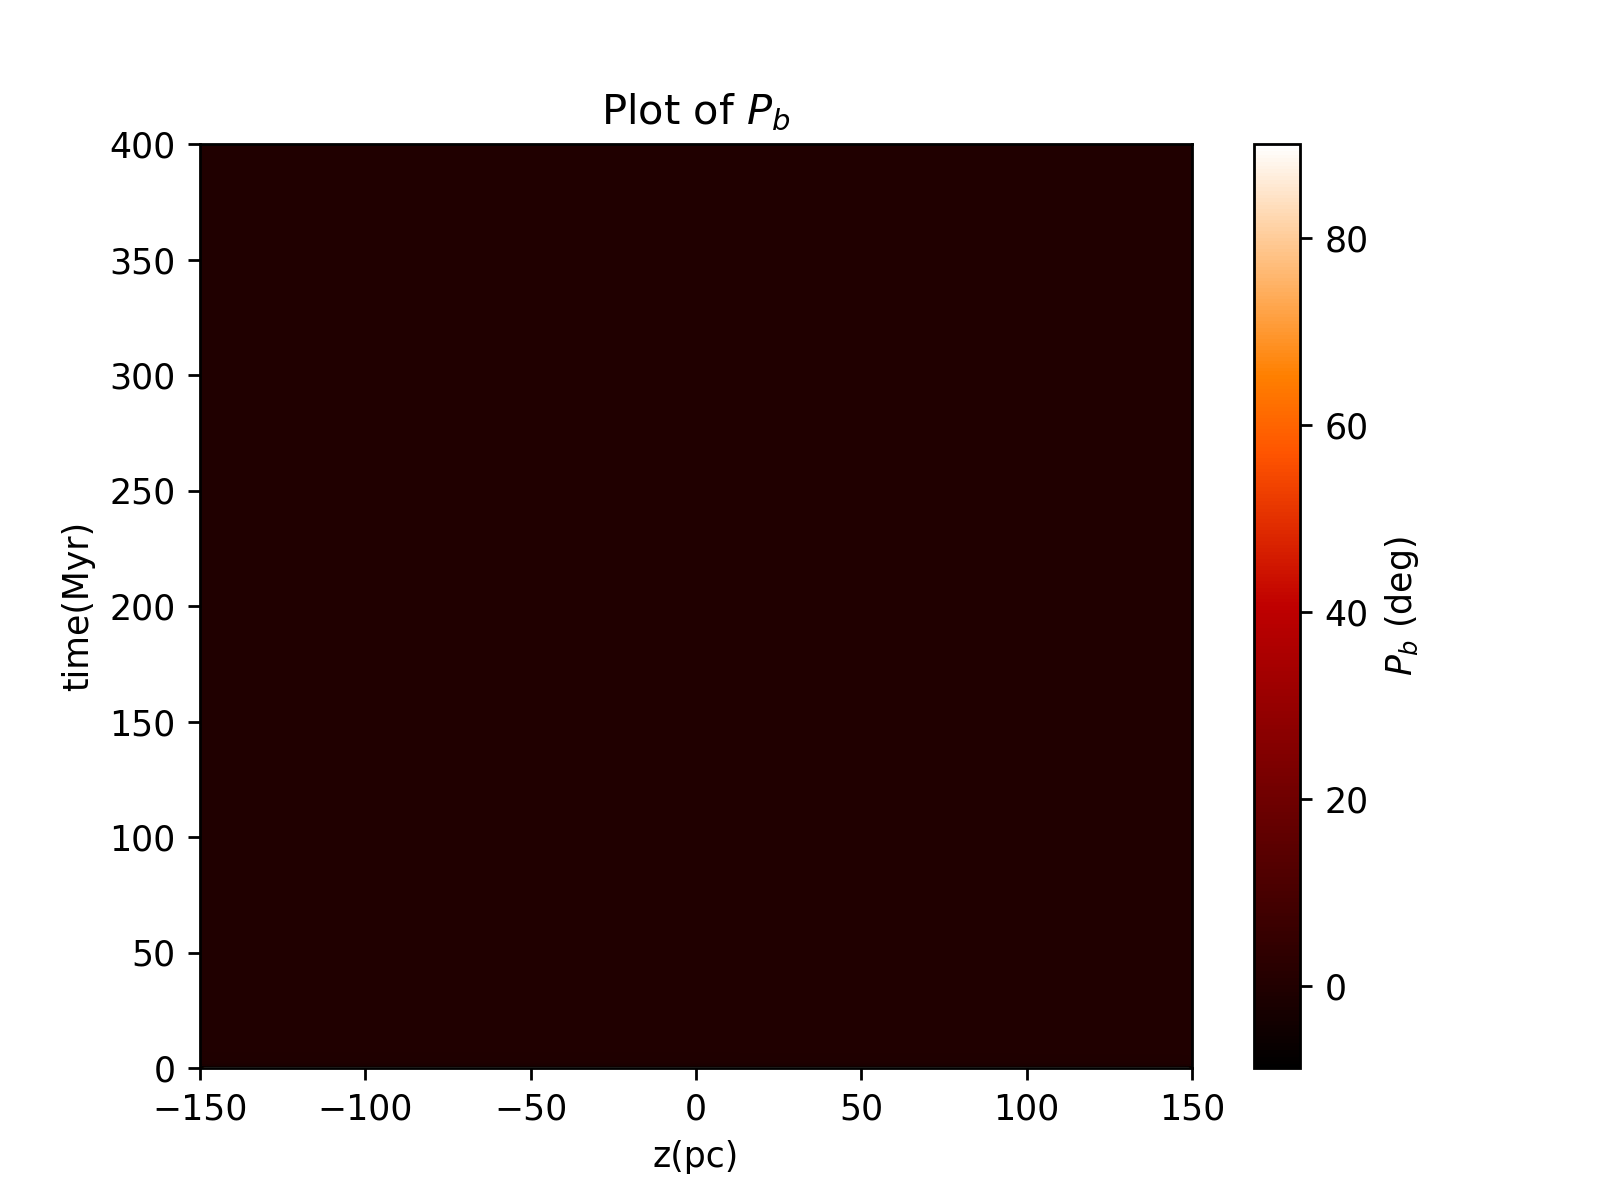

In [49]:
fig1=plt.figure(dpi=250)
plt.imshow(p_b, cmap='gist_heat', origin='lower', aspect='auto',extent=[z_min, z_max, 0, t_f])
plt.colorbar(label=r'$P_b$ (deg)')
plt.xlabel('z(pc)')
plt.ylabel('time(Myr)')
plt.title(r'Plot of $P_{b}$')
plt.savefig('images_sim/P_b22_heat.png')
plt.show()

In [50]:
create_ani(p_b[:][:,1:-1][::7],z_val[1:-1],t_val[::7],'animations/P_b22.gif',['z (pc)',r'$P_b$ (deg)'])

![Variation of Pitch angle with time](animations/P_b22.gif?dummy=11353133)

Calculating critical dynamo number

In [51]:
tol = 1e-4
alpha_0_c, x_arr, y_arr = bisection(c_dynamo, 0.001, 0.05, tol)


Plotting the Convergence plot for critical Dynamo number

Critical Dynamo number Dc =  5.869


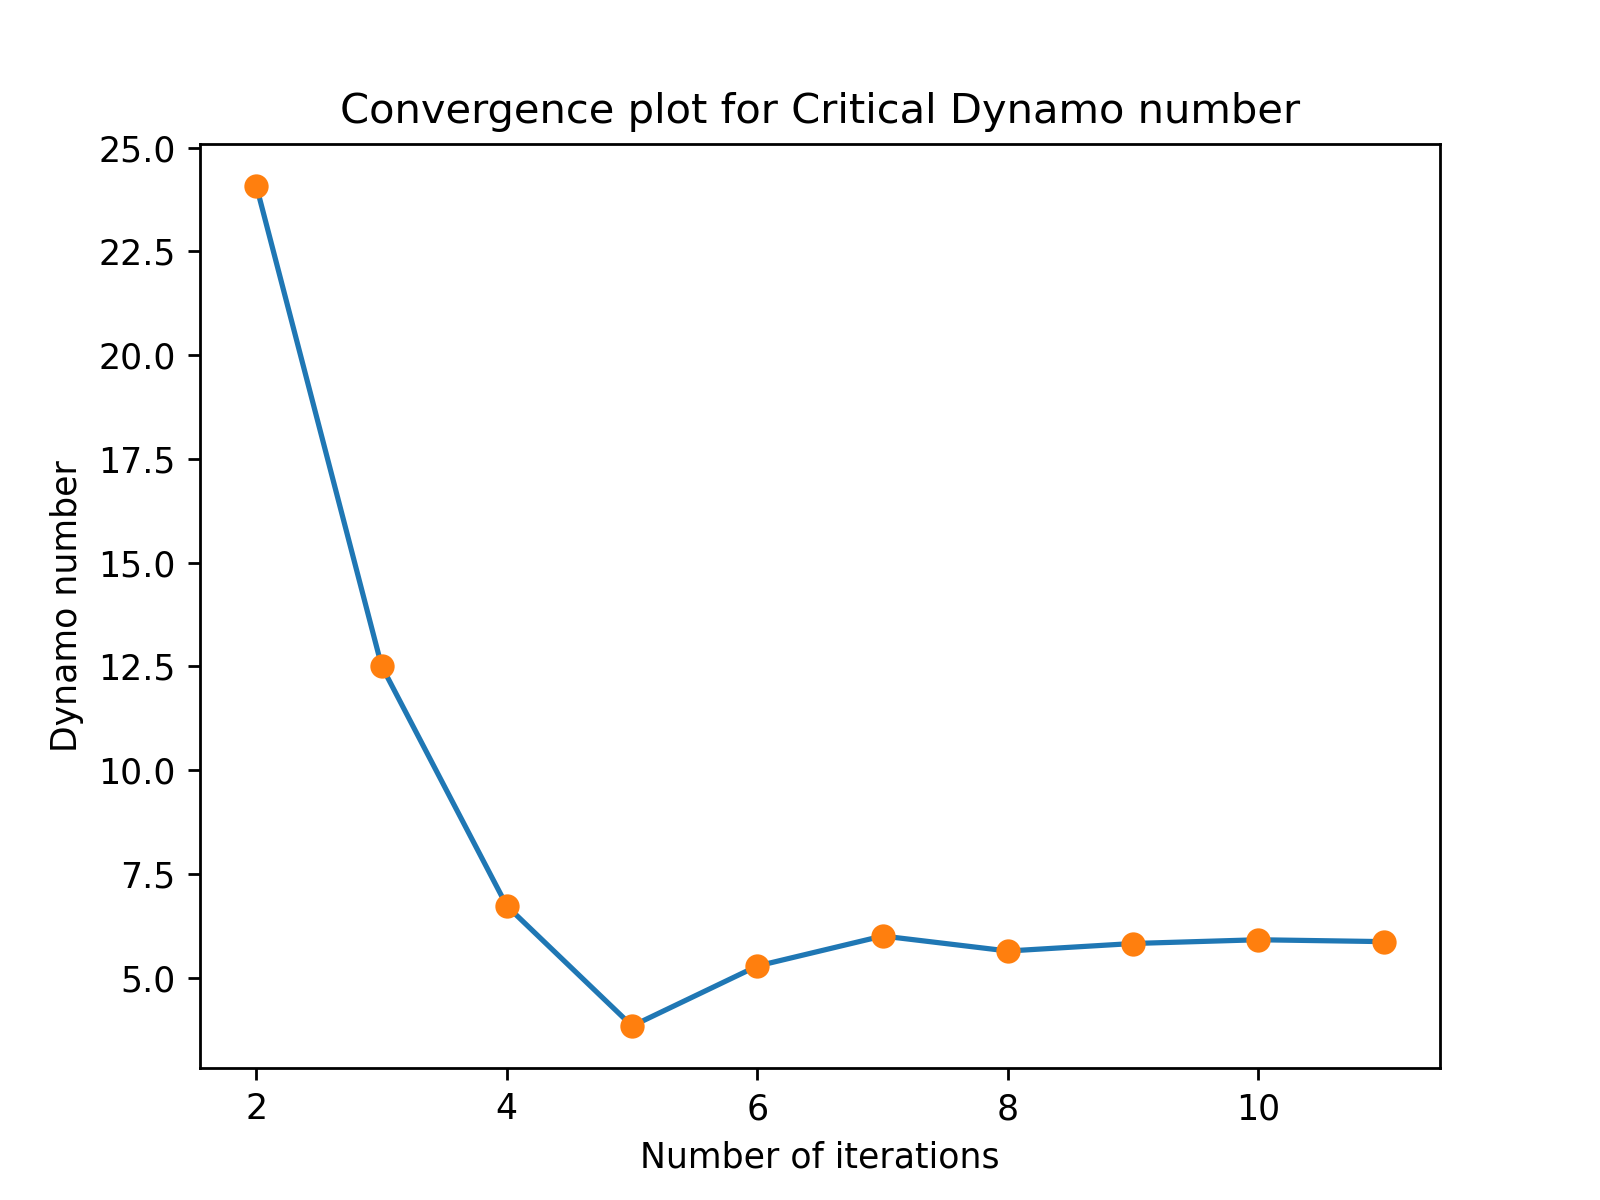

In [52]:
print('Critical Dynamo number Dc = ', np.round(alpha_0_c*Omega*(150**3)/eta**2, 4))
plt.figure(dpi=250)
plt.plot(x_arr, np.array(y_arr)*Omega*(150**3)/eta**2)
plt.plot(x_arr, np.array(y_arr)*Omega*(150**3)/eta**2, 'o')
plt.xlabel('Number of iterations')
plt.ylabel('Dynamo number')
plt.title('Convergence plot for Critical Dynamo number')
# plt.grid()
plt.savefig('images_sim/c_dynamo.png')
plt.show()

# Part 3

Modified Crank-nicolson function

In [90]:
def mod2_crank_nicolson(z,B0_r, dt, T,eta,alpha,Omega,q,B0_phi=None):
    """
    u0: initial condition, a function of x
    dx: space step size
    dt: time step size
    T: total time upto which integration is to be done
    """
    
    # Spatial grid
    G=len(B0_r)-1
    H=int(T/dt)
    # np.insert(alpha,G,alpha[-2])
    # Coefficients for the matrix A and B
    rho = eta*dt/(2*dz**2)
    mu=dt/(2*dz)*alpha
    # print(alpha*mu)
    sigma =-0.5*np.gradient(alpha,z)+mu
    U = np.zeros((2*G+2, H))
    np.insert(B0_r,0,B0_r[1])
    if B0_phi is None:
        B0_phi=np.zeros(B0_r.shape)
    else:
        np.insert(B0_phi,0,B0_phi[1])
    P = np.zeros((2*G+2, 2*G+2))
    Q = np.zeros((2*G+2, 2*G+2))
    for i in range(G+1):
        P[i, i] = 1+2*rho
        P[i, i+G] = -sigma[i]
        P[i+G, i] = q*Omega*dt/2
        P[i+G, i+G] = 1+2*rho
        Q[i, i] = 1-2*rho
        Q[i, i+G] = sigma[i]
        Q[i+G, i] = -q*Omega*dt/2
        Q[i+G, i+G] = 1-2*rho
        U[i, 0] = B0_r[i]
        U[G+i, 0] = B0_phi[i]
        if i<G-1:
            P[i, i+1] = -rho
            P[i, i+G+1] = mu[i]
            P[i+G, i+G+1] = -rho
            P[i+1, i] = -rho
            P[i+G+1, i+G] = -rho
            Q[i, i+1] = rho
            Q[i, i+G+1] = -mu[i]
            Q[i+G, i+G+1] = rho
            Q[i+1, i] = rho
            Q[i+G+1, i+G] = rho
    # Iterating for each time step
    for n in range(1,H):
        U[:, n] = np.dot(np.linalg.inv(P), np.dot(Q, U[:, n - 1]))
        U[0,n]=U[1,n]
        U[G+1,n]=U[G+3,n]
    return U[:G, :].T, U[G:, :].T

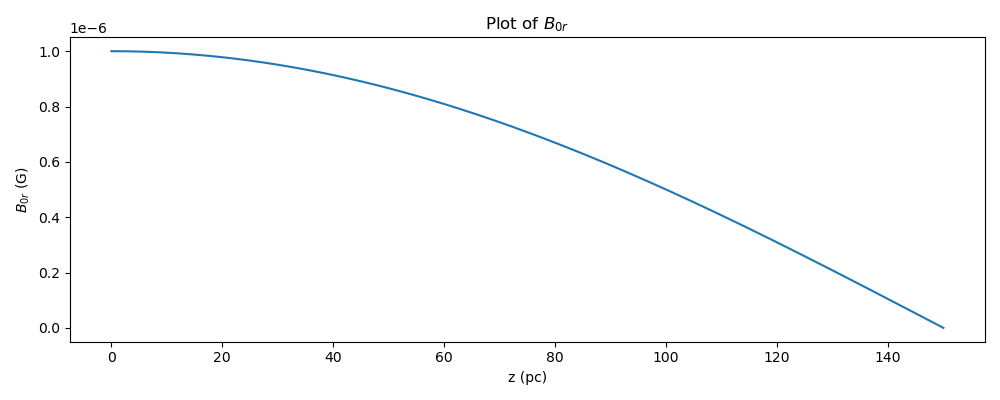

In [66]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

# Plot of B0_R
axs.plot(z_val[int(len(B0_R)/2):], B0_R[int(len(B0_R)/2):])
axs.set_xlabel('z (pc)')
axs.set_ylabel(r'$B_{0r}$ (G)')
axs.set_title(r'Plot of $B_{0r}$')

plt.savefig('images_sim/seed_field22.png')
plt.tight_layout()
plt.show()

In [89]:
print(int(int(B0_R[int(len(B0_R)/2):].shape[0])))

151


In [91]:
B_R,B_PHI = mod2_crank_nicolson(z_val[int(len(z_val)/2)-1:],B0_R[int(len(B0_R)/2):], dt, t_f,eta,alpha[int(len(alpha)/2)-1:],Omega,q)
fig1=plt.figure(dpi=250)
plt.imshow(B_R, cmap='gist_heat', origin='lower', aspect='auto',extent=[0, z_max, 0, t_f])
plt.colorbar(label=r'$B_{r}$ (G)')
plt.xlabel('z (pc)')
plt.ylabel('time (Myr)')
plt.title(r'Plot of $B_{r}$')
plt.savefig('images_sim/B_r31_heat.png')
plt.show()

LinAlgError: Singular matrix